# EDA

## Labels

Binarize the labels

In [1]:
import pandas as pd
import os
from Funcs.Utillity import *

LABELS = pd.read_csv(os.path.join(PATH_ESM, 'combined.csv')).assign(
    timestamp=lambda x: pd.to_datetime(x['respondAt'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
).set_index(
    ['uid', 'timestamp']
)
LABELS.head()
LABEL = LABELS.dropna(subset='stressLevel')
_LABELS = LABEL

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5')]

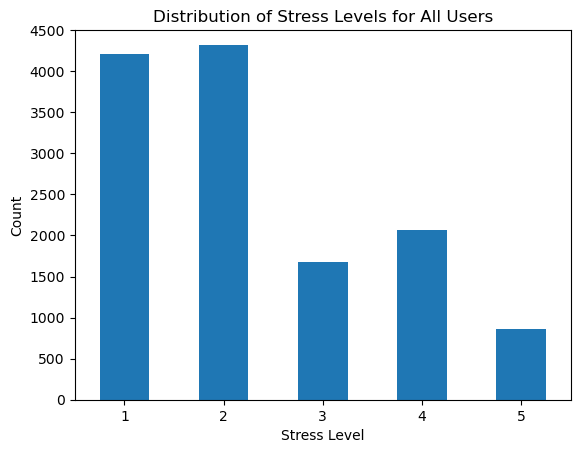

In [2]:
ax = _LABELS.stressLevel.value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Stress Level')
ax.set_ylabel('Count')
ax.set_ylim(0, 4500)  # Adjust the y-axis limit as needed
ax.set_title('Distribution of Stress Levels for All Users')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

## Feature Candidates

In [6]:
DATA = load(os.path.join('Intermediate', 'proc_interpretable_updated.pkl'))

In [7]:
DATA.keys()

dict_keys(['APP_DUR_SOCIAL', 'APP_DUR_SYSTEM', 'APP_DUR_WORK', 'APP_DUR_ENTER', 'APP_DUR_INFO', 'APP_DUR_HEALTH', 'APP_CAT', 'LOC_LABEL', 'LOC_DST', 'ACT_DUR_WALKING', 'ACT_DUR_STILL', 'ACT_DUR_IN_VEHICLE', 'ACT_DUR_ON_BICYCLE', 'ACT_DUR_RUNNING', 'LOC_DUR_social', 'LOC_DUR_none', 'LOC_DUR_work', 'LOC_DUR_eating', 'LOC_DUR_home', 'LOC_DUR_others', 'LOC_DUR_gym'])

In [111]:
# Initialize new dictionary
reorganized_data = {}


for key, series in DATA.items():
    for (pcode, timestamp), value in series.items():
        if pcode not in reorganized_data:
            reorganized_data[pcode] = {}
        if key not in reorganized_data[pcode]:
            reorganized_data[pcode][key] = []
        reorganized_data[pcode][key].append((timestamp, value))

# Convert lists to DataFrames for better usability
for pcode in reorganized_data:
    for key in reorganized_data[pcode]:
        reorganized_data[pcode][key] = pd.DataFrame(reorganized_data[pcode][key], columns=['timestamp', 'value']).set_index('timestamp')

del DATA

In [112]:
reorganized_data['P02'].keys()

dict_keys(['APP_DUR_SOCIAL', 'APP_DUR_SYSTEM', 'APP_DUR_WORK', 'APP_DUR_ENTER', 'APP_DUR_INFO', 'APP_CAT', 'LOC_LABEL', 'LOC_DST', 'ACT_DUR_WALKING', 'ACT_DUR_STILL', 'ACT_DUR_IN_VEHICLE', 'ACT_DUR_ON_BICYCLE', 'ACT_DUR_RUNNING', 'LOC_DUR_social', 'LOC_DUR_none', 'LOC_DUR_work', 'LOC_DUR_eating', 'LOC_DUR_home', 'LOC_DUR_others'])

In [114]:
reorganized_data.keys()

dict_keys(['P23', 'P13', 'P10', 'P05', 'P04', 'P15', 'P21', 'P22', 'P03', 'P08', 'P02', 'P11', 'P12', 'P14', 'P24', 'P27', 'P19', 'P07', 'P06', 'P18', 'P20', 'P25', 'P17', 'P26'])

In [8]:

EXCLUDE_DTYPE = [ 'APP_DUR_UNKNOWN', 'LOC_DUR_others', 'APP_CAT_UNKNOWN']

for pcode in LABEL.index.droplevel('timestamp').unique():
    data = reorganized_data[pcode]
    data = {
        k: v
        for k, v in data.items()
        if k not in EXCLUDE_DTYPE
    }
    dump(data, f'./proc/clean_data-{pcode}.pkl')

In [10]:
del reorganized_data

# Data Resampling

Get a list of unqiue values of categorical data

In [2]:
pids = LABEL.index.get_level_values('uid').unique().tolist()

In [5]:
from collections import defaultdict

CATEGORIES = defaultdict(list)


for pcode in pids:
    d = load(f'./proc/clean_data-{pcode}.pkl')
    
    for c in [
         'LOC_LABEL',  'APP_CAT'
    ]:
        CATEGORIES[c].extend(list(filter(lambda x: x is not None, d[c]['value'].unique()))) #filter null values
#CATEGORIES is a list of unique values of categorical data
CATEGORIES = {
    k: None if v is None else list(set(v))
    for k, v in CATEGORIES.items()
}

Resample at 1 second interval

In [6]:
import pandas as pd
import ray
from Funcs.Utillity import load, dump

# Constants (adjust as needed)
RESAMPLE_FREQUENCY = 1

# Check if Ray is already initialized
if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)
else:
    print("Ray is already initialized.")
    ray.shutdown()
    ray.init(ignore_reinit_error=True)


@ray.remote
def resample_data(pcode, data, resample_frequency, categories, default_tz):
    data_resampled = dict()
    for k, v in data.items():
        v = v.loc[lambda x: ~x.index.duplicated(keep=False)]  # Remove duplicate values including the first value
        v = v.reset_index().assign(timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_convert(default_tz)).set_index('timestamp')
        if k in categories:
            # Forward fill for categorical data
            data_resampled[k] = v.resample(f'{resample_frequency}S').ffill().dropna() if resample_frequency > 0 and len(v) > 0 else v
        else:
            # Mean and interpolate for non-categorical data
            data_resampled[k] = v.resample(f'{resample_frequency}S').mean().interpolate(method='linear').dropna() if resample_frequency > 0 and len(v) > 0 else v

    file_path = os.path.join(PATH_HOME, 'proc',f'resampled_data-{pcode}.pkl')
    dump(data_resampled, file_path)
    return file_path

# Run the resampling in parallel for each pcode
futures = [resample_data.remote(pcode, load(f'./proc/clean_data-{pcode}.pkl'), RESAMPLE_FREQUENCY, CATEGORIES, DEFAULT_TZ) for pcode in pids]
results = ray.get(futures)

# Print the paths of the saved files
for result in results:
    print(result)

# Shutdown Ray
ray.shutdown()

2025-01-21 16:08:24,334	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P07.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P15.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P10.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P20.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P04.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P26.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P27.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P23.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P14.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P12.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P17.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P25.pkl
/var/nfs_share/CausalAnalysisBehaviorFeatures/proc/resampled_data-P02.pkl
/var/nfs_share/CausalAnalysisBehaviorF

In [26]:
# RESAMPLE_FREQUENCY = 1

# for pcode in pids:
#     data = reorganized_data[pcode]
#     data_resampled = dict()
#     for k, v in data.items():
#         v = v.loc[lambda x: ~x.index.duplicated(keep=False)] # ~ means not， remove duplicate values including the first value
#         v.reset_index().assign(timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)).set_index('timestamp')
#         if k in CATEGORIES:
#             #ffill https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna
#             data_resampled[k] = v.resample(f'{RESAMPLE_FREQUENCY}S').ffill().dropna() if RESAMPLE_FREQUENCY > 0 and len(v) > 0 else v
#         else:
#             data_resampled[k] = v.resample(f'{RESAMPLE_FREQUENCY}S').mean().interpolate(method='linear').dropna() if RESAMPLE_FREQUENCY > 0 and len(v) > 0 else v
                    
#         dump(data_resampled, f'./proc/resampled_data-{pcode}.pkl')

# RuleGenerateSet

load the label data for RuleGenerateSet

## Extract Sub-features

### Resampled

First extract sub features before each ESm response using different combinations of window size and number of sub-time windows

In [1]:
# windows = [40,80,160]
# num_sub_windows = [2,4,8]
windows = [160]
num_sub_windows = [8]

In [9]:
from itertools import product
import os.path as osp
from Funcs.Feature_extraction import *
resample = True
resample_str = '' if resample else '_no_resample'

#for nsub, window_size_in_min in product(num_sub_windows,windows)[1:]:
for i,(nsub, window_size_in_min) in enumerate(product(num_sub_windows,windows)):
    fn = f'Features/arm/subfeature{resample_str}_{window_size_in_min}MIN_{nsub}.csv'
    if not osp.exists(fn):
        print(f'extracting {fn} ')
        with on_ray(ignore_reinit_error=True):    
            sub_features = parallellize_extract_sub(
                labels=_LABELS
                , w_size_in_min = window_size_in_min
                ,num_sub=nsub
                , resample =resample
            )
        sub_features.to_csv(fn)

extracting Features/arm/subfeature_160MIN_8.csv 


2025-01-21 16:16:15,523	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
  0%|          | 0/24 [00:00<?, ?it/s](extract_sub pid=195493) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
(extract_sub pid=195493)   d_value = _raw[_d_name][_s:_e]
(extract_sub pid=195467) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:230: FutureWarni
(extract_sub pid=195467) ng: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
(extract_sub pid=195482) /var/nfs_share/CausalAnalysisBehaviorF
2025-01-21 16:16:18,370	WARNING worker.py:820 -- The driver may not be able to keep up with the stdout/stderr of the workers. T

(extract_sub pid=195492) [25-01-21 16:16:23] Complete feature extraction (n = 2144, dim = 32).


2025-01-21 16:16:23,941	WARNING worker.py:820 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.
(extract_sub pid=195493)   d_value = _
(extract_sub pid=195493) raw[_d_name][_s:_e]
2025-01-21 16:16:24,352	WARNING worker.py:820 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.
(extract_sub pid=195491) /var/n
  8%|▊         | 2/24 [00:09<01:28,  4.03s/it](extract_sub pid=195469) /var/nfs_share
(extract_sub pid=195493) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyErr
(extract_sub pid=195493) or in a future version. Use a timezone-aware object instead.
(extract_sub pid=195474) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Fea

(extract_sub pid=195496) [25-01-21 16:16:28] Complete feature extraction (n = 3576, dim = 31). [repeated 7x across cluster]


(extract_sub pid=195474) /var/n
2025-01-21 16:16:29,774	WARNING worker.py:820 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.
2025-01-21 16:16:29,788	WARNING worker.py:820 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.
2025-01-21 16:16:29,803	WARNING worker.py:820 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.
2025-01-21 16:16:29,821	WARNING worker.py:820 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.
2025-01-21 16:16:29,841	WARNING worker.py:820 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to th

(extract_sub pid=195487) [25-01-21 16:16:35] Complete feature extraction (n = 5808, dim = 32). [repeated 10x across cluster]


 79%|███████▉  | 19/24 [00:19<00:03,  1.44it/s](extract_sub pid=195497) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead. [repeated 45802x across cluster]
(extract_sub pid=195497)   d_value = _raw[_d_name][_s:_e] [repeated 45802x across cluster]
(extract_sub pid=195497) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise 
(extract_sub pid=195497) KeyError in a future version. Use a timezone-aware object instead.
(extract_sub pid=195497) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in 

(extract_sub pid=195489) [25-01-21 16:17:08] Complete feature extraction (n = 3744, dim = 30). [repeated 2x across cluster]


(extract_sub pid=195468) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use 
(extract_sub pid=195468) a timezone-aware object instead.
(extract_sub pid=195470)   d_value = _raw[_d
(extract_sub pid=195470) _name][_s:_e]
(extract_sub pid=195470) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a fu
(extract_sub pid=195470) ture version. Use a timezone-aware object instead.
(extract_sub pid=195468) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:
 88%|████████▊ | 21/24 [00:53<00:21,  7.24s/it](extract_sub pid=195497) /var/nfs_share
(extract_sub pid=195472) /var/nfs_share/CausalAnalysisBehaviorFeatures/Funcs/Feature_extraction.py:230: F

(extract_sub pid=195472) [25-01-21 16:17:13] Complete feature extraction (n = 5104, dim = 32). [repeated 4x across cluster]


### No Resampling

In [29]:
# from itertools import product
# import os.path as osp
# from Funcs.Feature_extraction import *
# resample = False
# resample_str = '' if resample else '_no_resample'

# #for nsub, window_size_in_min in product(num_sub_windows,windows)[1:]:
# for i,(nsub, window_size_in_min) in enumerate(product(num_sub_windows,windows)):
#     fn = f'Features/arm/subfeature{resample_str}_{window_size_in_min}MIN_{nsub}.csv'
#     if not osp.exists(fn):
#         print(f'extracting {fn} ')
#         with on_ray(ignore_reinit_error=True):    
#             sub_features = parallellize_extract_sub(
#                 labels=_LABELS
#                 , w_size_in_min = window_size_in_min
#                 ,num_sub=nsub
#                 ,resample =resample
#             )
#         sub_features.to_csv(fn)

### Extract Extended Features

In [30]:
# from Funcs.Feature_extraction import extract_extended_parallel
# extended_features_arm = extract_extended_parallel(
#         labels=labels_arm
#     )
# extended_features_arm.to_csv(f'Features/arm/extended_arm.csv')

In [31]:
# sub_features.reset_index().set_index(['pid','timestamp']).keys()


## Extract Aggregated Features from Sub Features

In [2]:
from Funcs.Utillity import normalize
from Funcs.Feature_extraction import impute_support_features
def read_sub_features(window_size_in_min, nsub):
    fn = f'Features/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
    print(f'reading {fn}')
    sub_features = pd.read_csv(
        fn
        ,dtype={'pid':str}
        ,parse_dates=['timestamp','sub_timestamp']
    ).set_index(['pid','timestamp','sub_timestamp'])
    return sub_features


def get_agg_features(window_size_in_min , nsub):
    sub_features = read_sub_features(window_size_in_min, nsub)
    sub_features_preprocessed =impute_support_features(normalize(sub_features))

    agg_feature = sub_features_preprocessed.groupby(
        ['pid','timestamp']
    ).agg(['mean','std'])
    agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
    return agg_feature

## Time Window Selection

### Optimizing window size and number of sub-time windows

#### Criteria 1 Checking missing values

In [5]:
window_size_in_min = 160
nsub=8
sub_features = pd.read_csv(
        f'Features/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
    ).set_index(['pid','timestamp','sub_timestamp']) 

In [34]:
# import pandas as pd
# from itertools import product
# from Funcs.Feature_extraction import impute_support_features


# measurement = pd.DataFrame( columns=[
#     'number of subwindows'
#     ,'window size'
# ])

# for nsub, window_size_in_min in product(num_sub_windows,windows):
#     sub_features = pd.read_csv(
#         f'Features/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
#     ).set_index(['pid','timestamp','sub_timestamp']) 
#     N,D = sub_features.shape

#     sub_features = impute_support_features(sub_features) # (num_esm*nsub, D)
#     ds = sub_features.isnull().sum(axis=0)/N # dimenstion is ( D,)
    
#     measurement = pd.concat(
#         [
#             measurement
#             ,pd.DataFrame({
#                 'number of subwindows':[nsub]
#                 ,'window size':[window_size_in_min]
#                 ,r'missing features % (threshold=20%)':[ds[ds>.2].sum()/D*100]
#                 ,r'missing features % (threshold=10%)':[ds[ds>.1].sum()/D*100]
#                 ,r'missing features % (threshold=2%)':[ds[ds>.02].sum()/D*100]
#                 ,r'missing features % (threshold=1%)':[ds[ds>.01].sum()/D*100]
#                 ,r'missing features % (threshold=0.5%)':[ds[ds>.005].sum()/D*100]

#             })
#         ]
#         , ignore_index=True
#     )

# pd.set_option("display.precision", 2)

# measurement = measurement.set_index([
#     'number of subwindows','window size'
# ]).sort_index()
# measurement.to_csv(f'Results/missing_feature_for_each_combinations_no_resample.csv')
# measurement

#### Criteria 2 Checking predictive power

In [35]:
# from Funcs.Model import *
# from Funcs.Utility import impute
# from itertools import product
# use_ray = False
# feature_selection={'status':False}

In [36]:

# measure_list=[]
# for i,(nsub, window_size_in_min) in enumerate(product(num_sub_windows,windows)):
#     print( f'#### nsub, window_size_in_min = {nsub}, {window_size_in_min}####')
#     f = get_agg_features(window_size_in_min,nsub)
    

#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore") 
#         measure = run_classification(
#             pd.merge(
#                 labels_arm['sts_dyn'],
#                 impute(f)
#                 ,left_index=True, right_index=True
#             ) 
#             ,use_ray=use_ray, feature_selection=feature_selection,
#             experiment_name=f'({nsub},{window_size_in_min})'
#             , classifier_name='lr'
#         )
#         measure_list.append(measure)
# all_measures = pd.concat(measure_list)
# all_measures.groupby(['CV_TYPE','experiment']).mean()

The final selected combination is # of sub window = 8 and window size = 80 minutes

## Feature Selection

In [6]:
WINDOW_SIZE_IN_MIN, NSUB =  160, 8

In [7]:
agg_feature = get_agg_features(WINDOW_SIZE_IN_MIN, NSUB)
agg_feature.isnull().sum(axis=0).sort_values(ascending=False).head(12)

reading Features/arm/subfeature_160MIN_8.csv


LOC_DUR_gym#SUM|std            10129
LOC_DUR_gym#SUM|mean           10124
APP_DUR_HEALTH#SUM|std          6507
APP_DUR_HEALTH#SUM|mean         6500
ACT_DUR_RUNNING#SUM|std         5455
ACT_DUR_RUNNING#SUM|mean        5443
ACT_DUR_ON_BICYCLE#SUM|std      2833
ACT_DUR_ON_BICYCLE#SUM|mean     2827
LOC_DUR_social#SUM|std           829
LOC_DUR_social#SUM|mean          823
ACT_DUR_IN_VEHICLE#SUM|std       796
ACT_DUR_IN_VEHICLE#SUM|mean      790
dtype: int64

In [8]:
# Drop columns containing "others" or "UNKNOWN" in their names (not interpretable)
columns_to_drop = [col for col in agg_feature.columns if 'others' in col or 'UNKNOWN' in col]
agg_feature = agg_feature.drop(columns=columns_to_drop)

In [13]:
feature_selection_meta = pd.DataFrame(columns=['Removal step', 'Remaining number of features'])
feature_selection_meta = feature_selection_meta.append({
    'Removal step':'Original AFs', 'Remaining number of features':60
},ignore_index=True)
feature_selection_meta

/tmp/ipykernel_202300/195747505.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_selection_meta = feature_selection_meta.append({


,Removal step,Remaining number of features
0,Original AFs,60


### zero variance features removal

In [14]:
agg_feature.var().sort_values(ascending=False).head(12)

LOC_LABEL#SUP:home|mean      0.180288
LOC_LABEL#SUP:eating|mean    0.061247
LOC_LABEL#SUP:work|mean      0.054538
LOC_DUR_gym#SUM|mean         0.040374
LOC_LABEL#SUP:social|mean    0.033532
LOC_LABEL#SUP:home|std       0.030125
APP_CAT#SUP:ENTER|mean       0.029827
APP_CAT#SUP:ENTER|std        0.022037
LOC_LABEL#SUP:work|std       0.021036
LOC_LABEL#SUP:none|mean      0.020924
LOC_LABEL#SUP:eating|std     0.019343
APP_CAT#SUP:SOCIAL|mean      0.019064
dtype: float64

In [15]:
def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var
agg_feature_non_zero_var = exclude_low_variance(agg_feature)

0/60 features with variance < 1e-07 removed


In [16]:
feature_selection_meta = feature_selection_meta.append({
    'Removal step':'Elimination of zero variance features', 'Remaining number of features':60
},ignore_index=True)
feature_selection_meta

/tmp/ipykernel_202300/3443183278.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_selection_meta = feature_selection_meta.append({


,Removal step,Remaining number of features
0,Original AFs,60
1,Elimination of zero variance features,60


### missing count thresholding
- discard if the feature is missing more than 20% of the time

In [17]:
def exclude_missing(agg_feature_non_zero_var, threshold=.2):
    missing_ratio = agg_feature_non_zero_var.isnull().sum(axis=0)/len(agg_feature_non_zero_var)

    agg_feature_percent_missing  = agg_feature_non_zero_var.loc[
        :,(missing_ratio[missing_ratio<threshold]).index
    ]
    num_removed = agg_feature_non_zero_var.shape[1]-agg_feature_percent_missing.shape[1]
    print(f"{num_removed}/{agg_feature_non_zero_var.shape[1]} mostly missing features are removed")
    return agg_feature_percent_missing

    # visuzlize missing ratio
    # fig_size = figsize=(10,5)
    # f, ax = plt.subplots(figsize=fig_size)


    # N, D = agg_feature_non_zero_var.shape
    # missing_ratio.sort_values(ascending=False).plot(linewidth=3)
    # I = np.arange(0,D,50)
    # ax.set_xticks(I,  I)
    # ax.grid()
    # ax.set_xlabel('Sorted Feature Index')
    # ax.set_ylabel('Percentage of missing cases')
      

agg_feature_percent_missing = exclude_missing(
    agg_feature_non_zero_var, threshold=.2)
agg_feature_percent_missing

8/60 mostly missing features are removed


APP_DUR_SOCIAL#SUM|mean  \
pid timestamp                                                   
P02 2023-03-22 11:57:45.146000+09:00                      NaN   
    2023-03-22 12:35:47.731000+09:00                      NaN   
    2023-03-22 13:29:55.238000+09:00                      NaN   
    2023-03-22 14:24:44.722000+09:00                      NaN   
    2023-03-22 15:12:32.421000+09:00                      NaN   
...                                                       ...   
P27 2023-05-11 15:52:39.387000+09:00                      NaN   
    2023-05-11 16:22:54.393000+09:00                      NaN   
    2023-05-11 16:53:19.053000+09:00                      NaN   
    2023-05-11 17:26:44.678000+09:00                      NaN   
    2023-05-11 22:39:22.894000+09:00                      NaN   

                                      APP_DUR_SOCIAL#SUM|std  \
pid timestamp                                                  
P02 2023-03-22 11:57:45.146000+09:00                     NaN   
    2023-03-22 12:35:47.731000+09:00                     NaN   
    2023-03-22 13:29:55.238000+09:00                     NaN   
    2023-03-22 14:24:44.722000+09:00                     NaN   
    2023-03-22 15:12:32.421000+09:00                     NaN   
...                                                      ...   
P27 2023-05-11 15:52:39.387000+09:00                     NaN   
    2023-05-11 16:22:54.393000+09:00                     NaN   
    2023-05-11 16:53:19.053000+09:00                     NaN   
    2023-05-11 17:26:44.678000+09:00                     NaN   
    2023-05-11 22:39:22.894000+09:00                     NaN   

                                      APP_DUR_SYSTEM#SUM|mean  \
pid timestamp                                                   
P02 2023-03-22 11:57:45.146000+09:00                      NaN   
    2023-03-22 12:35:47.731000+09:00                      NaN   
    2023-03-22 13:29:55.238000+09:00                      NaN   
    2023-03-22 14:24:44.722000+09:00                      NaN   
    2023-03-22 15:12:32.421000+09:00                      NaN   
...                                                       ...   
P27 2023-05-11 15:52:39.387000+09:00                      NaN   
    2023-05-11 16:22:54.393000+09:00                      NaN   
    2023-05-11 16:53:19.053000+09:00                      NaN   
    2023-05-11 17:26:44.678000+09:00                      NaN   
    2023-05-11 22:39:22.894000+09:00                      NaN   

                                      APP_DUR_SYSTEM#SUM|std  \
pid timestamp                                                  
P02 2023-03-22 11:57:45.146000+09:00                     NaN   
    2023-03-22 12:35:47.731000+09:00                     NaN   
    2023-03-22 13:29:55.238000+09:00                     NaN   
    2023-03-22 14:24:44.722000+09:00                     NaN   
    2023-03-22 15:12:32.421000+09:00                     NaN   
...                                                      ...   
P27 2023-05-11 15:52:39.387000+09:00                     NaN   
    2023-05-11 16:22:54.393000+09:00                     NaN   
    2023-05-11 16:53:19.053000+09:00                     NaN   
    2023-05-11 17:26:44.678000+09:00                     NaN   
    2023-05-11 22:39:22.894000+09:00                     NaN   

                                      APP_DUR_WORK#SUM|mean  \
pid timestamp                                                 
P02 2023-03-22 11:57:45.146000+09:00                    NaN   
    2023-03-22 12:35:47.731000+09:00                    NaN   
    2023-03-22 13:29:55.238000+09:00                    NaN   
    2023-03-22 14:24:44.722000+09:00                    NaN   
    2023-03-22 15:12:32.421000+09:00                    NaN   
...                                                     ...   
P27 2023-05-11 15:52:39.387000+09:00                    NaN   
    2023-05-11 16:22:54.393000+09:00                    NaN   
    2023-05-11 16:53:19.053000+09:00              

In [18]:
feature_selection_meta = feature_selection_meta.append({
    'Removal step':'Elimination of mostly missing features', 'Remaining number of features':52
},ignore_index=True)
feature_selection_meta

/tmp/ipykernel_202300/1099560496.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_selection_meta = feature_selection_meta.append({


,Removal step,Remaining number of features
0,Original AFs,60
1,Elimination of zero variance features,60
2,Elimination of mostly missing features,52


### Pairwise Correlation

#### prepare features order
- features highly correlated with target variable should come first in corr matrix

In [17]:
# corr_with_outcome = pd.merge(
#     _LABELS['stressLevel'],
#     agg_feature_percent_missing
#     ,left_index=True, right_index=True
# ).corr()['stressLevel'].abs().sort_values(ascending=False)

# corr_with_outcome

In [18]:
# importance_order = corr_with_outcome.index.to_list()[1:] # remove `sts_dyn`
# Matrix = agg_feature_percent_missing[importance_order].corr()

#### remove pairwise corr. features

In [19]:
# from tqdm import tqdm
# def remove_pairwise_corr(
#     agg_feature_percent_missing
#     , PAIRWISE_CORR_THRESHOLD = 0.8
#     , outcome_varible=None
#     ):
#     if outcome_varible is not None:
#         # order by correlation with outcome
#         corr_with_outcome = pd.merge(
#             outcome_varible,
#             agg_feature_percent_missing
#             ,left_index=True, right_index=True
#         ).corr()[outcome_varible.name].abs().sort_values(ascending=False)
#         importance_order = corr_with_outcome.index.to_list()[1:] # remove `sts_dyn`
#         agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

#     Matrix = agg_feature_percent_missing.corr()

#     eliminated_features = []
#     for r in tqdm(range(Matrix.shape[0])):
#         featurename = Matrix.index[r]   
        
#         if str(featurename) in eliminated_features:
#             continue
#         pairwise_corr = Matrix.iloc[r,r+1:]
#         eliminated_features+= pairwise_corr[
#             pairwise_corr>PAIRWISE_CORR_THRESHOLD
#         ].index.to_list()

#     kept_features = list(
#         set(Matrix.index.to_list()) - set(eliminated_features)
#     )
#     print(f"Pairwise Corr: keept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
#     return agg_feature_percent_missing[kept_features]

In [20]:
# agg_feature_after_corr = remove_pairwise_corr(
#     agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD = 0.8
#     , outcome_varible=_LABELS['stressLevel']
# )
# agg_feature_after_corr.shape[1]

In [21]:
# feature_selection_meta = feature_selection_meta.append({
#     'Removal step':'Elimination of pairwise correlations', 'Remaining number of features':93
# },ignore_index=True)
# feature_selection_meta

### LogReg+Lasso

In [22]:
# from sklearn.linear_model import LogisticRegression
# def exclude_with_lasso(features, outcome_ds):
#     data = pd.merge(
#             outcome_ds,
#             impute(
#                 features
#             )
#             ,left_index=True, right_index=True
#     )

#     clf = LogisticRegression(
#         penalty='l1' 
#         ,solver='liblinear'
#         , C=1, random_state=RANDOM_STATE, max_iter=4000
#     )
#     clf.fit(
#         data.drop(['stressLevel'], axis=1)
#         , data['stressLevel']
#     )

#     lasso_features = np.array(
#         features.columns.tolist()
#     )[np.abs(clf.coef_[0])>0.005]
#     print(f"LASSO:kept only {len(lasso_features)}/{len(features.columns)} features")
#     return features[lasso_features], clf

In [23]:
# from matplotlib import pyplot as plt
# from Funcs.Utillity import impute, RANDOM_STATE
# import numpy as np
# import matplotlib
# lasso_features, clf = exclude_with_lasso(features=agg_feature_after_corr, outcome_ds=_LABELS['stressLevel'])
# num_features = lasso_features.shape[1]
# matplotlib.rc('font', size=22)

# plt.figure(figsize=(10,7))
# plt.grid()
# plt.plot(np.sort(np.abs(clf.coef_[0])), linewidth=5, 
#     label = 'LogReg+Lasso Coefficients'
# )
# plt.xlabel('Sorted Feature Index')
# plt.ylabel("Absolute value of coefficient")

# plt.plot(
#     [len(clf.coef_[0]) - num_features,len(clf.coef_[0])- num_features]
#     ,[0,np.max(np.abs(clf.coef_[0]))], color='red', linewidth=3
#     , label='Zero coefficient threshold'
# )
# plt.legend()


In [24]:
# lasso_features

In [25]:
# feature_selection_meta = feature_selection_meta.append({
#     'Removal step':'Lasso', 'Remaining number of features':3
# },ignore_index=True)
# feature_selection_meta

In [26]:
# feature_selection_meta.to_csv('Results/feature_selection_meta.csv', index=False)

### Save selected features

In [19]:
agg_feature_names_selected = agg_feature_percent_missing.columns.to_list()
selected_features = list(
    set(map(lambda x: x[:x.find('|')], agg_feature_percent_missing))
)
print(len(selected_features))
pd.DataFrame({
    'features':selected_features
}).to_csv('Features/selected_features.csv',index=False)

26


## Feature Preparation before Rule Mining

### Get the selected features for rule mining

In [20]:
select_features = pd.read_csv(
                    'Features/selected_features.csv'
                )['features'].values.tolist()

In [21]:
# Forward & backward fill missing values
sub_features = sub_features.fillna(method='ffill').fillna(method='bfill')


### Extract Temporal Features from Sub Time Windows

In [30]:
# from Funcs.Utillity import on_ray
# from Funcs.Feature_extraction import *

In [31]:
# SUBWINDOW_SIZE_IN_MIN = WINDOW_SIZE_IN_MIN//NSUB

# fn = f'Features/arm/sliding_window_{SUBWINDOW_SIZE_IN_MIN}_features_{len(select_features)}.csv'

# if not os.path.exists(fn) :
#     with on_ray( ignore_reinit_error=True):    
#         sliding_features = parallellize_extract_sliding(
#                 labels=_LABELS 
#                 , _sw_size_in_min = SUBWINDOW_SIZE_IN_MIN
#                 , selected_features=pd.read_csv(
#                     'Features/selected_features.csv'
#                 )['features'].values.tolist()
#                 , resample = True
#         )
#     sliding_features.to_csv(fn)

# sliding_features = pd.read_csv(
#     fn
#     , dtype={'pid':'str'}
#     , parse_dates=['timestamp']
# ).set_index(['pid','timestamp'])

# sliding_features = impute(
#     impute_support_features(
#         sliding_features
#     )
# )

### Perform Categorization 
- Transform the raw values of temporal features by re-coding them into different levels: low, moderate, and high 
- Use person specific thresholds based on quantiles: 33%, 66%tile 


In [23]:
from copy import deepcopy        
def discretize_df(data, cols, pid):
    df = deepcopy(data)
    count1,count2, count3 = 0,0,0
    for col in cols:
        try:
            df[col] = pd.qcut(df[col], 3, labels=["l","m","h"])
            count3 += 1
        except:
            try:
                df[col] = pd.qcut(df[col], 2, labels=["l","h"])
                count2 += 1
            except:
                df[col] = pd.qcut(df[col], 1, labels=["m"])
                count1 += 1
    df.insert(0,'pid',pid)
          
    df = df.reset_index().set_index(['pid']+data.index.names)
    print(f'count1,count2, count3 = {count1},{count2}, {count3}')
    return df

In [24]:
from tqdm import tqdm
df_recoded = [] 
arm_pids = sub_features.index.get_level_values('pid').unique()
cols = sub_features.columns.tolist()
for pid in tqdm(arm_pids):    
    res = discretize_df(
        sub_features.loc[pid]
        , cols
        , pid
    )
    df_recoded.append(res)
df_recoded = pd.concat(df_recoded)
df_recoded = df_recoded.astype('str').fillna('missing').astype('category')
df_recoded.head()


 38%|███▊      | 9/24 [00:00<00:00, 42.25it/s]

count1,count2, count3 = 15,1, 16
count1,count2, count3 = 14,2, 16
count1,count2, count3 = 14,0, 18
count1,count2, count3 = 11,2, 19
count1,count2, count3 = 15,0, 17
count1,count2, count3 = 15,0, 17
count1,count2, count3 = 14,2, 16
count1,count2, count3 = 13,4, 15
count1,count2, count3 = 12,2, 18


 58%|█████▊    | 14/24 [00:00<00:00, 41.93it/s]

count1,count2, count3 = 15,1, 16
count1,count2, count3 = 12,2, 18
count1,count2, count3 = 15,0, 17
count1,count2, count3 = 15,0, 17
count1,count2, count3 = 11,3, 18
count1,count2, count3 = 12,4, 16
count1,count2, count3 = 14,1, 17
count1,count2, count3 = 14,0, 18
count1,count2, count3 = 13,1, 18


100%|██████████| 24/24 [00:00<00:00, 41.81it/s]

count1,count2, count3 = 12,1, 19
count1,count2, count3 = 16,0, 16
count1,count2, count3 = 16,0, 16
count1,count2, count3 = 13,0, 19
count1,count2, count3 = 14,2, 16
count1,count2, count3 = 14,2, 16


APP_DUR_SOCIAL#SUM  \
pid timestamp                        sub_timestamp                                
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                  l   
                                     2023-03-22 00:57:28.996                  l   
                                     2023-03-22 01:17:28.996                  l   
                                     2023-03-22 01:37:28.996                  l   
                                     2023-03-22 01:57:28.996                  l   

                                                             APP_DUR_SYSTEM#SUM  \
pid timestamp                        sub_timestamp                                
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                  m   
                                     2023-03-22 00:57:28.996                  m   
                                     2023-03-22 01:17:28.996                  m   
                                     2023-03-22 01:37:28.996                  m   
                                     2023-03-22 01:57:28.996                  m   

                                                             APP_DUR_WORK#SUM  \
pid timestamp                        sub_timestamp                              
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                l   
                                     2023-03-22 00:57:28.996                l   
                                     2023-03-22 01:17:28.996                l   
                                     2023-03-22 01:37:28.996                l   
                                     2023-03-22 01:57:28.996                l   

                                                             APP_DUR_ENTER#SUM  \
pid timestamp                        sub_timestamp                               
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                 m   
                                     2023-03-22 00:57:28.996                 m   
                                     2023-03-22 01:17:28.996                 m   
                                     2023-03-22 01:37:28.996                 m   
                                     2023-03-22 01:57:28.996                 m   

                                                             APP_DUR_INFO#SUM  \
pid timestamp                        sub_timestamp                              
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                l   
                                     2023-03-22 00:57:28.996                l   
                                     2023-03-22 01:17:28.996                l   
                                     2023-03-22 01:37:28.996                l   
                                     2023-03-22 01:57:28.996                l   

                                                             APP_CAT#SUP:ENTER  \
pid timestamp                        sub_timestamp                               
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                 m   
                                     2023-03-22 00:57:28.996                 m   
                                     2023-03-22 01:17:28.996                 m   
                                     2023-03-22 01:37:28.996                 m   
                                     2023-03-22 01:57:28.996                 m   

                                                             APP_CAT#SUP:INFO  \
pid timestamp                        sub_timestamp                              
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                m   
                                     2023-03-22 00:57:28.996                m   
                                     2023-03-22 01:17:28.996                m   
                                     2023-03-22 01:37:28.996                m   
                                     2023-03-22 01:57:28.996                m   

                                           

In [25]:
non_varying_columns = df_recoded.nunique().sort_values()[df_recoded.nunique().sort_values()==1].index
non_varying_columns

Index(['APP_CAT#SUP:HEALTH', 'LOC_LABEL#SUP:gym', 'LOC_LABEL#SUP:none',
       'LOC_LABEL#SUP:others', 'APP_CAT#SUP:ENTER', 'APP_CAT#SUP:INFO',
       'LOC_LABEL#SUP:eating', 'LOC_LABEL#SUP:social', 'APP_CAT#SUP:WORK'],
      dtype='object')

In [26]:
len(non_varying_columns)

9

In [27]:
df_recoded = df_recoded.drop(non_varying_columns, axis=1)
df_recoded.shape

(105072, 23)

In [28]:
df_recoded

APP_DUR_SOCIAL#SUM  \
pid timestamp                        sub_timestamp                                
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                  l   
                                     2023-03-22 00:57:28.996                  l   
                                     2023-03-22 01:17:28.996                  l   
                                     2023-03-22 01:37:28.996                  l   
                                     2023-03-22 01:57:28.996                  l   
...                                                                         ...   
P03 2023-05-03 21:21:07.966000+09:00 2023-05-03 11:01:07.966                  h   
                                     2023-05-03 11:21:07.966                  h   
                                     2023-05-03 11:41:07.966                  h   
                                     2023-05-03 12:01:07.966                  h   
                                     2023-05-03 12:21:07.966                  h   

                                                             APP_DUR_SYSTEM#SUM  \
pid timestamp                        sub_timestamp                                
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                  m   
                                     2023-03-22 00:57:28.996                  m   
                                     2023-03-22 01:17:28.996                  m   
                                     2023-03-22 01:37:28.996                  m   
                                     2023-03-22 01:57:28.996                  m   
...                                                                         ...   
P03 2023-05-03 21:21:07.966000+09:00 2023-05-03 11:01:07.966                  m   
                                     2023-05-03 11:21:07.966                  h   
                                     2023-05-03 11:41:07.966                  m   
                                     2023-05-03 12:01:07.966                  l   
                                     2023-05-03 12:21:07.966                  m   

                                                             APP_DUR_WORK#SUM  \
pid timestamp                        sub_timestamp                              
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                l   
                                     2023-03-22 00:57:28.996                l   
                                     2023-03-22 01:17:28.996                l   
                                     2023-03-22 01:37:28.996                l   
                                     2023-03-22 01:57:28.996                l   
...                                                                       ...   
P03 2023-05-03 21:21:07.966000+09:00 2023-05-03 11:01:07.966                l   
                                     2023-05-03 11:21:07.966                l   
                                     2023-05-03 11:41:07.966                l   
                                     2023-05-03 12:01:07.966                l   
                                     2023-05-03 12:21:07.966                l   

                                                             APP_DUR_ENTER#SUM  \
pid timestamp                        sub_timestamp                               
P07 2023-03-22 11:57:28.996000+09:00 2023-03-22 00:37:28.996                 m   
                                     2023-03-22 00:57:28.996                 m   
                                     2023-03-22 01:17:28.996                 m   
                                     2023-03-22 01:37:28.996                 m   
                                     2023-03-22 01:57:28.996                 m   
...                                                                        ...   
P03 2023-05-03 21:21:07.966000+09:00 2023-05-03 11:01:07.966                 m   
                                     2023-05-03 11:21:07.966                 l   
                           

In [29]:
df_recoded.to_csv('Results/df_recoded.csv')

## Rule Mining & Selecting

### Orson's way

### Jumabek's way

#### Convert the features into transaction list

In [30]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import (
    apriori, fpmax,fpgrowth, association_rules
)

dataset = []
for i, r in df_recoded.iterrows():
    transaction = [f'{featurename}:{value}' 
                   for featurename, value in zip(r.index, r.values)]
    dataset.append(transaction)

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,ACT_DUR_IN_VEHICLE#SUM:h,ACT_DUR_IN_VEHICLE#SUM:l,ACT_DUR_IN_VEHICLE#SUM:m,ACT_DUR_ON_BICYCLE#SUM:h,ACT_DUR_ON_BICYCLE#SUM:l,ACT_DUR_ON_BICYCLE#SUM:m,ACT_DUR_RUNNING#SUM:h,ACT_DUR_RUNNING#SUM:l,ACT_DUR_RUNNING#SUM:m,ACT_DUR_STILL#SUM:h,...,LOC_DUR_social#SUM:m,LOC_DUR_work#SUM:h,LOC_DUR_work#SUM:l,LOC_DUR_work#SUM:m,LOC_LABEL#SUP:home:h,LOC_LABEL#SUP:home:l,LOC_LABEL#SUP:home:m,LOC_LABEL#SUP:work:h,LOC_LABEL#SUP:work:l,LOC_LABEL#SUP:work:m
0,False,True,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,True
1,False,True,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,True
2,False,True,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,True
3,False,True,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,True
4,False,True,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105067,True,False,False,False,True,False,False,False,True,False,...,True,False,True,False,False,False,True,False,False,True
105068,True,False,False,False,True,False,False,False,True,False,...,True,False,True,False,False,False,True,False,False,True
105069,True,False,False,False,True,False,False,False,True,False,...,True,False,True,False,False,False,True,False,False,True
105070,True,False,False,False,True,False,False,False,True,False,...,True,False,True,False,False,False,True,False,False,True


In [31]:
# Filter out columns that contain ':nan' in their names
valid_columns = [col for col in df.columns if ':nan' not in col]

# Retain only the valid columns in sub_features
df = df[valid_columns]


#### Mine frequent itemsets from transaction list


In [63]:
frequent_itemsets = fpgrowth(
    df, min_support=0.3, use_colnames=True,
    max_len=5
)

frequent_itemsets

,support,itemsets
0,0.979595,(LOC_LABEL#SUP:work:m)
1,0.873154,(APP_CAT#SUP:SOCIAL:m)
2,0.804839,(LOC_LABEL#SUP:home:m)
3,0.703746,(APP_CAT#SUP:SYSTEM:m)
4,0.700853,(LOC_DUR_gym#SUM:m)
...,...,...
178,0.341690,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ..."
179,0.343840,"(APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m, ..."
180,0.341690,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ..."
181,0.334885,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ..."


#### Association rule mining

In [73]:
res = association_rules(
    frequent_itemsets
    , metric='confidence'
    ,  min_threshold=0.8
)
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(APP_CAT#SUP:SOCIAL:m),(LOC_LABEL#SUP:work:m),0.873154,0.979595,0.852749,0.976631,0.996974,-0.002588,0.873154,-0.023369
1,(LOC_LABEL#SUP:work:m),(APP_CAT#SUP:SOCIAL:m),0.979595,0.873154,0.852749,0.870511,0.996974,-0.002588,0.979595,-0.129489
2,(LOC_LABEL#SUP:home:m),(LOC_LABEL#SUP:work:m),0.804839,0.979595,0.798034,0.991545,1.012199,0.009618,2.413390,0.061754
3,(LOC_LABEL#SUP:work:m),(LOC_LABEL#SUP:home:m),0.979595,0.804839,0.798034,0.814657,1.012199,0.009618,1.052973,0.590639
4,(LOC_LABEL#SUP:home:m),(APP_CAT#SUP:SOCIAL:m),0.804839,0.873154,0.707096,0.878556,1.006188,0.004348,1.044488,0.031510
...,...,...,...,...,...,...,...,...,...,...
251,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ...","(APP_CAT#SUP:SOCIAL:m, LOC_LABEL#SUP:work:m)",0.341690,0.852749,0.334885,0.980085,1.149324,0.043509,7.393874,0.197359
252,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ...","(APP_CAT#SUP:SOCIAL:m, APP_CAT#SUP:SYSTEM:m)",0.390580,0.703746,0.334885,0.857404,1.218343,0.060016,2.077575,0.294071
253,"(APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m)","(LOC_LABEL#SUP:home:m, APP_CAT#SUP:SYSTEM:m, L...",0.407045,0.570780,0.334885,0.822722,1.441400,0.102552,2.421170,0.516447
254,"(APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SYSTEM:m)","(LOC_LABEL#SUP:home:m, APP_CAT#SUP:SOCIAL:m, L...",0.364245,0.700291,0.334885,0.919393,1.312872,0.079807,3.718137,0.374848


##### Len(Consequent)=1

In [74]:
res_with_single_RHS = res[res.apply(lambda x: len(x['consequents'])==1, axis=1)]
res_with_single_RHS

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(APP_CAT#SUP:SOCIAL:m),(LOC_LABEL#SUP:work:m),0.873154,0.979595,0.852749,0.976631,0.996974,-0.002588,0.873154,-0.023369
1,(LOC_LABEL#SUP:work:m),(APP_CAT#SUP:SOCIAL:m),0.979595,0.873154,0.852749,0.870511,0.996974,-0.002588,0.979595,-0.129489
2,(LOC_LABEL#SUP:home:m),(LOC_LABEL#SUP:work:m),0.804839,0.979595,0.798034,0.991545,1.012199,0.009618,2.413390,0.061754
3,(LOC_LABEL#SUP:work:m),(LOC_LABEL#SUP:home:m),0.979595,0.804839,0.798034,0.814657,1.012199,0.009618,1.052973,0.590639
4,(LOC_LABEL#SUP:home:m),(APP_CAT#SUP:SOCIAL:m),0.804839,0.873154,0.707096,0.878556,1.006188,0.004348,1.044488,0.031510
...,...,...,...,...,...,...,...,...,...,...
240,"(APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SYSTEM:m, ...",(LOC_LABEL#SUP:home:m),0.343840,0.804839,0.334885,0.973954,1.210123,0.058149,7.492871,0.264627
243,"(APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m, ...",(LOC_LABEL#SUP:home:m),0.343840,0.804839,0.334885,0.973954,1.210123,0.058149,7.492871,0.264627
244,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ...",(LOC_LABEL#SUP:work:m),0.341690,0.979595,0.334885,0.980085,1.000500,0.000167,1.024591,0.000759
245,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ...",(APP_CAT#SUP:SYSTEM:m),0.351102,0.703746,0.334885,0.953810,1.355333,0.087798,6.413795,0.404029


In [75]:
res_with_single_RHS.consequents.nunique()

5

### Select rules with diversity and lift

#### Select rules with diversity

In [76]:
top_diverse_rules = pd.concat([
    frame.sort_values('lift', ascending=False).iloc[:30] \
    for i, frame in res_with_single_RHS.groupby('consequents')
])

In [77]:
top_diverse_rules = pd.concat([
    frame.sort_values('lift', ascending=False).iloc[:30] \
    for i, frame in res_with_single_RHS.groupby('consequents')
])

top_diverse_rules = top_diverse_rules[top_diverse_rules.lift>1].sort_values(
    'lift'
    , ascending=False
).iloc[:200]


print(top_diverse_rules.consequents.nunique())
top_diverse_rules

5


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
232,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ...",(APP_CAT#SUP:SYSTEM:m),0.357907,0.703746,0.341690,0.954688,1.356580,0.089814,6.538103,0.409368
245,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ...",(APP_CAT#SUP:SYSTEM:m),0.351102,0.703746,0.334885,0.953810,1.355333,0.087798,6.413795,0.404029
101,"(APP_DUR_HEALTH#SUM:m, APP_CAT#SUP:SOCIAL:m, L...",(APP_CAT#SUP:SYSTEM:m),0.359316,0.703746,0.324520,0.903163,1.283364,0.071653,3.059293,0.344628
94,"(APP_CAT#SUP:SOCIAL:m, APP_DUR_HEALTH#SUM:m, L...",(APP_CAT#SUP:SYSTEM:m),0.359316,0.703746,0.324520,0.903163,1.283364,0.071653,3.059293,0.344628
222,"(APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m)",(APP_CAT#SUP:SYSTEM:m),0.407045,0.703746,0.364245,0.894854,1.271558,0.077789,2.817542,0.360167
...,...,...,...,...,...,...,...,...,...,...
6,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:SOCIAL:m)",(LOC_LABEL#SUP:work:m),0.707096,0.979595,0.700291,0.990376,1.011006,0.007623,2.120299,0.037166
23,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:SYSTEM:m)",(LOC_LABEL#SUP:work:m),0.577585,0.979595,0.570780,0.988218,1.008803,0.004981,1.731947,0.020658
26,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:SOCIAL:m, A...",(LOC_LABEL#SUP:work:m),0.577585,0.979595,0.570780,0.988218,1.008803,0.004981,1.731947,0.020658
61,(APP_DUR_HEALTH#SUM:m),(LOC_LABEL#SUP:work:m),0.510669,0.979595,0.503874,0.986693,1.007246,0.003625,1.533437,0.014702


Save rules

In [78]:
top_diverse_rules.loc[:,"antecedents"] = top_diverse_rules["antecedents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode").values

top_diverse_rules.loc[:,"consequents"] = top_diverse_rules["consequents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode").values

top_diverse_rules.to_csv(f'Results/top_diverse_rules.csv', index=False)

In [79]:
top_diverse_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
232,"LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, A...",APP_CAT#SUP:SYSTEM:m,0.357907,0.703746,0.341690,0.954688,1.356580,0.089814,6.538103,0.409368
245,"LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, A...",APP_CAT#SUP:SYSTEM:m,0.351102,0.703746,0.334885,0.953810,1.355333,0.087798,6.413795,0.404029
101,"APP_DUR_HEALTH#SUM:m, APP_CAT#SUP:SOCIAL:m, LO...",APP_CAT#SUP:SYSTEM:m,0.359316,0.703746,0.324520,0.903163,1.283364,0.071653,3.059293,0.344628
94,"APP_CAT#SUP:SOCIAL:m, APP_DUR_HEALTH#SUM:m, LO...",APP_CAT#SUP:SYSTEM:m,0.359316,0.703746,0.324520,0.903163,1.283364,0.071653,3.059293,0.344628
222,"APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m",APP_CAT#SUP:SYSTEM:m,0.407045,0.703746,0.364245,0.894854,1.271558,0.077789,2.817542,0.360167
...,...,...,...,...,...,...,...,...,...,...
6,"LOC_LABEL#SUP:home:m, APP_CAT#SUP:SOCIAL:m",LOC_LABEL#SUP:work:m,0.707096,0.979595,0.700291,0.990376,1.011006,0.007623,2.120299,0.037166
23,"LOC_LABEL#SUP:home:m, APP_CAT#SUP:SYSTEM:m",LOC_LABEL#SUP:work:m,0.577585,0.979595,0.570780,0.988218,1.008803,0.004981,1.731947,0.020658
26,"LOC_LABEL#SUP:home:m, APP_CAT#SUP:SOCIAL:m, AP...",LOC_LABEL#SUP:work:m,0.577585,0.979595,0.570780,0.988218,1.008803,0.004981,1.731947,0.020658
61,APP_DUR_HEALTH#SUM:m,LOC_LABEL#SUP:work:m,0.510669,0.979595,0.503874,0.986693,1.007246,0.003625,1.533437,0.014702


#### Select rules only with top lift

In [80]:
res_with_single_RHS.consequents.nunique()

5

In [81]:
res_with_single_RHS = res_with_single_RHS.sort_values('lift', ascending=False)
top_rules_with_lift = res_with_single_RHS[
    res_with_single_RHS.lift>1
]
top_rules_with_lift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
232,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ...",(APP_CAT#SUP:SYSTEM:m),0.357907,0.703746,0.341690,0.954688,1.356580,0.089814,6.538103,0.409368
245,"(LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, ...",(APP_CAT#SUP:SYSTEM:m),0.351102,0.703746,0.334885,0.953810,1.355333,0.087798,6.413795,0.404029
101,"(APP_DUR_HEALTH#SUM:m, APP_CAT#SUP:SOCIAL:m, L...",(APP_CAT#SUP:SYSTEM:m),0.359316,0.703746,0.324520,0.903163,1.283364,0.071653,3.059293,0.344628
94,"(APP_CAT#SUP:SOCIAL:m, APP_DUR_HEALTH#SUM:m, L...",(APP_CAT#SUP:SYSTEM:m),0.359316,0.703746,0.324520,0.903163,1.283364,0.071653,3.059293,0.344628
222,"(APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m)",(APP_CAT#SUP:SYSTEM:m),0.407045,0.703746,0.364245,0.894854,1.271558,0.077789,2.817542,0.360167
...,...,...,...,...,...,...,...,...,...,...
136,(APP_DUR_ENTER#SUM:l),(LOC_LABEL#SUP:work:m),0.334123,0.979595,0.327318,0.979634,1.000040,0.000013,1.001902,0.000059
119,(ACT_DUR_IN_VEHICLE#SUM:l),(LOC_LABEL#SUP:work:m),0.333971,0.979595,0.327166,0.979624,1.000030,0.000010,1.001446,0.000045
152,(LOC_DUR_none#SUM:m),(LOC_LABEL#SUP:work:m),0.333267,0.979595,0.326471,0.979610,1.000015,0.000005,1.000734,0.000023
150,(LOC_DUR_work#SUM:m),(LOC_LABEL#SUP:work:m),0.333267,0.979595,0.326471,0.979610,1.000015,0.000005,1.000734,0.000023


In [82]:
top_200_rules_with_lift = top_rules_with_lift.iloc[:200]

In [83]:
top_200_rules_with_lift.consequents.nunique()

5

In [84]:
top_200_rules_with_lift.loc[:,"antecedents"] = top_200_rules_with_lift["antecedents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode").values

top_200_rules_with_lift.loc[:,"consequents"] = top_200_rules_with_lift["consequents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode").values

top_200_rules_with_lift.to_csv(f'Results/top_rules_with_lift.csv', index=False)

# TrainEvalSet

In [85]:
import pandas as pd
selected_features = pd.read_csv('Features/selected_features.csv')['features'].to_list()
len(selected_features),selected_features[:5]

(26,
 ['LOC_LABEL#SUP:social',
  'APP_CAT#SUP:SOCIAL',
  'APP_DUR_SOCIAL#SUM',
  'LOC_DUR_social#SUM',
  'APP_DUR_WORK#SUM'])

In [55]:
# def extract_label(path):
#     labels = pd.read_csv(path)
#     labels['timestamp'] = pd.to_datetime(labels["timestamp"]) #since when we save the csv, the datetime format is not well saved. It will be converted to string type by default.
#     labels = labels.set_index(['pcode','timestamp'])
#     return labels

In [56]:
# labels_ml=extract_label("Labels/labels_ml.csv")

## Feature Extraction

### Full feature extraction(w/ feature selection)

In [86]:
# WINDOW_SIZE_IN_MIN,len(selected_features)

In [58]:
# fn = f'Features/ml/full_{WINDOW_SIZE_IN_MIN}MIN_dim={len(selected_features)}.csv'
# fn

In [59]:
# from Funcs.Feature_extraction import parallellize_extract
# from Funcs.Utility import on_ray
# select_features = pd.read_csv(
#                     'Features/selected_features.csv'
#                 )['features'].values.tolist()
# fn = f'Features/ml/full_{WINDOW_SIZE_IN_MIN}MIN_dim={len(select_features)}.csv'
# if not os.path.exists(fn):
#     print("Extracting features...")
#     with on_ray(ignore_reinit_error=True, num_cpus=6):
#         ml_full_features = parallellize_extract(
#             labels=labels_ml, 
#             w_size_in_min=WINDOW_SIZE_IN_MIN,
#             selected_features=selected_features
#             , use_ray =True
#         )
#         ml_full_features.to_csv(fn)
# ml_full_features = pd.read_csv(
#     fn
#     , dtype={'pid':'str'}
#     , parse_dates=['timestamp']
# ).set_index(['pid','timestamp'])
# ml_full_features

In [60]:
# ml_full_features.isnull().sum().sort_values(ascending=False)

### Full feature extraction(w/o feature selection)

In [61]:
# from Funcs.Feature_extraction import parallellize_extract
# from Funcs.Utility import on_ray

# fn = f'Features/ml/full_{WINDOW_SIZE_IN_MIN}MIN_noFeatureSelection.csv'
# if not os.path.exists(fn):
#     print("Extracting features...")
#     with on_ray(ignore_reinit_error=True, num_cpus=6):
#         ml_full_features_noFeatureSelection = parallellize_extract(
#             labels=labels_ml, 
#             w_size_in_min=WINDOW_SIZE_IN_MIN,
#             selected_features=False,
#              use_ray =False
#         )
#         ml_full_features_noFeatureSelection.to_csv(fn)
# ml_full_features_noFeatureSelection = pd.read_csv(
#     fn
#     , dtype={'pid':'str'}
#     , parse_dates=['timestamp']
# ).set_index(['pid','timestamp'])
# ml_full_features_noFeatureSelection

### Aggregated feature extraction

#### Extract temporal features from sub windows

In [62]:
# from itertools import product
# from Funcs.Feature_extraction import parallellize_extract_sub
# selected_features = pd.read_csv(
#                     'Features/selected_features.csv'
#                 )['features'].values.tolist()

# fn = f'Features/ml/subfeature_{WINDOW_SIZE_IN_MIN}MIN_{NSUB}_dim={len(selected_features)}.csv'
# if not os.path.exists(fn):
#     with on_ray(ignore_reinit_error=True, num_cpus=6):    
#         ml_sub_features = parallellize_extract_sub(
#             labels=labels_ml
#             , w_size_in_min = WINDOW_SIZE_IN_MIN
#             ,num_sub=NSUB
#             , selected_features=selected_features
#         ) # 15min
#         ml_sub_features.to_csv(fn)
# else:
#     ml_sub_features = pd.read_csv(
#         fn
#         , dtype={'pid':'str'}
#         , parse_dates=['timestamp','sub_timestamp']
#     ).set_index(['pid','timestamp','sub_timestamp'])

In [93]:
# ml_sub_features.isnull().sum().sort_values(ascending=False)

#### Aggregate features from sub windows in each time window


In [94]:
# from Funcs.Feature_extraction import impute_support_features
# from Funcs.Utility import normalize
# ml_agg_feature = impute_support_features(
#     normalize(ml_sub_features)
# ).groupby(
#     ['pid','timestamp']
# ).agg(['mean','std'])
# ml_agg_feature.columns = ml_agg_feature.columns.map('|'.join).str.strip('|')
# ml_agg_feature.to_csv(
#     f'Features/ml/agg_feature_{WINDOW_SIZE_IN_MIN}MIN_{NSUB}.csv'
# )

In [95]:
# ml_agg_feature.isnull().sum().sort_values(ascending=False)

### CFF extraction

#### Categorize the sub features

load df_recoded to get the selected features

In [87]:
def extract_df_recoded(path):
    df_recoded = pd.read_csv(path)
    df_recoded['timestamp'] = pd.to_datetime(df_recoded["timestamp"]) #since when we save the csv, the datetime format is not well saved. It will be converted to string type by default.
    df_recoded = df_recoded.set_index(['pid','timestamp'])
    return df_recoded

In [88]:
df_recoded = extract_df_recoded("Results/df_recoded.csv")

In [89]:
df_recoded = df_recoded.drop(columns='sub_timestamp')

In [90]:
from tqdm import tqdm
from Funcs.Utillity import impute
ml_sub_features_p = impute(
    impute_support_features(
        sub_features[df_recoded.columns]
    )
)

ml_sub_recoded = [] 
ml_pids = ml_sub_features_p.index.get_level_values('pid').unique()
cols = ml_sub_features_p.columns.tolist()
ml_sub_recoded = pd.concat([
    discretize_df(ml_sub_features_p.loc[pid],cols, pid) for pid in tqdm(ml_pids)
])
    
ml_sub_recoded = ml_sub_recoded.astype('str').fillna(
    'missing'
).astype('category')
ml_sub_recoded

 29%|██▉       | 7/24 [00:00<00:00, 60.37it/s]

count1,count2, count3 = 6,0, 17
count1,count2, count3 = 5,2, 16
count1,count2, count3 = 6,0, 17
count1,count2, count3 = 3,4, 16
count1,count2, count3 = 7,0, 16
count1,count2, count3 = 6,1, 16
count1,count2, count3 = 3,1, 19
count1,count2, count3 = 5,0, 18
count1,count2, count3 = 5,1, 17
count1,count2, count3 = 6,1, 16
count1,count2, count3 = 5,0, 18
count1,count2, count3 = 3,2, 18
count1,count2, count3 = 5,2, 16


100%|██████████| 24/24 [00:00<00:00, 62.60it/s]

count1,count2, count3 = 3,2, 18
count1,count2, count3 = 4,0, 19
count1,count2, count3 = 2,3, 18
count1,count2, count3 = 2,2, 19
count1,count2, count3 = 7,0, 16
count1,count2, count3 = 4,1, 18
count1,count2, count3 = 4,4, 15
count1,count2, count3 = 5,2, 16
count1,count2, count3 = 6,0, 17
count1,count2, count3 = 6,0, 17
count1,count2, count3 = 5,2, 16


APP_DUR_SOCIAL#SUM  \
pid timestamp                        sub_timestamp                                
P02 2023-03-22 11:57:45.146000+09:00 2023-03-22 00:37:45.146                  l   
                                     2023-03-22 00:57:45.146                  l   
                                     2023-03-22 01:17:45.146                  l   
                                     2023-03-22 01:37:45.146                  l   
                                     2023-03-22 01:57:45.146                  l   
...                                                                         ...   
P27 2023-05-11 22:39:22.894000+09:00 2023-05-11 12:19:22.894                  m   
                                     2023-05-11 12:39:22.894                  m   
                                     2023-05-11 12:59:22.894                  m   
                                     2023-05-11 13:19:22.894                  m   
                                     2023-05-11 13:39:22.894                  m   

                                                             APP_DUR_SYSTEM#SUM  \
pid timestamp                        sub_timestamp                                
P02 2023-03-22 11:57:45.146000+09:00 2023-03-22 00:37:45.146                  h   
                                     2023-03-22 00:57:45.146                  h   
                                     2023-03-22 01:17:45.146                  h   
                                     2023-03-22 01:37:45.146                  h   
                                     2023-03-22 01:57:45.146                  h   
...                                                                         ...   
P27 2023-05-11 22:39:22.894000+09:00 2023-05-11 12:19:22.894                  l   
                                     2023-05-11 12:39:22.894                  l   
                                     2023-05-11 12:59:22.894                  l   
                                     2023-05-11 13:19:22.894                  l   
                                     2023-05-11 13:39:22.894                  l   

                                                             APP_DUR_WORK#SUM  \
pid timestamp                        sub_timestamp                              
P02 2023-03-22 11:57:45.146000+09:00 2023-03-22 00:37:45.146                l   
                                     2023-03-22 00:57:45.146                l   
                                     2023-03-22 01:17:45.146                l   
                                     2023-03-22 01:37:45.146                l   
                                     2023-03-22 01:57:45.146                l   
...                                                                       ...   
P27 2023-05-11 22:39:22.894000+09:00 2023-05-11 12:19:22.894                l   
                                     2023-05-11 12:39:22.894                l   
                                     2023-05-11 12:59:22.894                l   
                                     2023-05-11 13:19:22.894                l   
                                     2023-05-11 13:39:22.894                l   

                                                             APP_DUR_ENTER#SUM  \
pid timestamp                        sub_timestamp                               
P02 2023-03-22 11:57:45.146000+09:00 2023-03-22 00:37:45.146                 l   
                                     2023-03-22 00:57:45.146                 l   
                                     2023-03-22 01:17:45.146                 l   
                                     2023-03-22 01:37:45.146                 l   
                                     2023-03-22 01:57:45.146                 l   
...                                                                        ...   
P27 2023-05-11 22:39:22.894000+09:00 2023-05-11 12:19:22.894                 m   
                                     2023-05-11 12:39:22.894                 m   
                           

In [91]:
ml_sub_recoded.shape

(105072, 23)

#### Extract the contextually-filtered features

##### Using rules w/o diversity

In [92]:
import logging
import numpy as np
features = {}
rules = pd.read_csv(
    f'Results/top_rules_with_lift.csv'
    , usecols=['antecedents','consequents']
    , dtype={'lift':float}
)
print("number of rules:",len(rules))


for i,rule in tqdm(rules.iterrows()):
    X, Y = rule['antecedents'], rule['consequents']
    y_name, y_val = Y[:-2], Y[-1]

    x_names = [x[:-2] for x in X.split(', ')]
    x_vals = [x[-1] for x in X.split(', ')]
    M = np.ones(len(ml_sub_recoded), dtype=bool)
    # if rule has context with length 2 {featureA:m, featureB:l}
    for xname, xval in zip(x_names, x_vals):
        M = M &( ml_sub_recoded[xname]==xval)


    selected_context = sub_features[M][y_name]
    f = selected_context.groupby([
        'pid','timestamp'
    ]).agg(['mean','std'])
    features[f'mean-{y_name}_context={X}'] = f['mean']
    features[f'std-{y_name}_context={X}'] = f['std']
featuresCFF = impute_support_features(
                pd.DataFrame(features )
)

featuresCFF.isnull().sum().sort_values(ascending=False)

number of rules: 148


148it [00:02, 50.90it/s]


mean-APP_CAT#SUP:SYSTEM_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m    0
std-APP_CAT#SUP:SOCIAL_context=APP_DUR_HEALTH#SUM:m                                                  0
std-LOC_LABEL#SUP:work_context=ACT_DUR_RUNNING#SUM:m, APP_CAT#SUP:SOCIAL:m, APP_CAT#SUP:SYSTEM:m     0
mean-LOC_LABEL#SUP:work_context=ACT_DUR_RUNNING#SUM:m, APP_CAT#SUP:SOCIAL:m, APP_CAT#SUP:SYSTEM:m    0
std-LOC_LABEL#SUP:work_context=ACT_DUR_RUNNING#SUM:m, APP_CAT#SUP:SYSTEM:m                           0
                                                                                                    ..
mean-APP_CAT#SUP:SYSTEM_context=APP_CAT#SUP:SOCIAL:m                                                 0
std-APP_CAT#SUP:SOCIAL_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:SYSTEM:m, LOC_LABEL#SUP:work:m      0
mean-APP_CAT#SUP:SOCIAL_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:SYSTEM:m, LOC_LABEL#SUP:work:m     0
std-APP_CAT#SUP:SOCIAL_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:

In [93]:
featuresCFF.fillna(0, inplace=True)

In [94]:
_LABELS

respondAt respondAt_date  \
pid timestamp                                                        
P07 2023-03-22 11:57:28.996000+09:00  1679453848996     2023-03-22   
    2023-03-22 12:33:39.048000+09:00  1679456019048     2023-03-22   
    2023-03-22 13:11:46.744000+09:00  1679458306744     2023-03-22   
    2023-03-22 13:59:26.389000+09:00  1679461166389     2023-03-22   
    2023-03-22 14:31:16.301000+09:00  1679463076301     2023-03-22   
...                                             ...            ...   
P03 2023-05-03 13:52:38.025000+09:00  1683089558025     2023-05-03   
    2023-05-03 14:53:56.368000+09:00  1683093236368     2023-05-03   
    2023-05-03 16:52:04.923000+09:00  1683100324923     2023-05-03   
    2023-05-03 19:22:29.907000+09:00  1683109349907     2023-05-03   
    2023-05-03 21:21:07.966000+09:00  1683116467966     2023-05-03   

                                     respondAt_dow respondAt_time  \
pid timestamp                                                       
P07 2023-03-22 11:57:28.996000+09:00           Wed          11:57   
    2023-03-22 12:33:39.048000+09:00           Wed          12:33   
    2023-03-22 13:11:46.744000+09:00           Wed          13:11   
    2023-03-22 13:59:26.389000+09:00           Wed          13:59   
    2023-03-22 14:31:16.301000+09:00           Wed          14:31   
...                                            ...            ...   
P03 2023-05-03 13:52:38.025000+09:00           Wed          13:52   
    2023-05-03 14:53:56.368000+09:00           Wed          14:53   
    2023-05-03 16:52:04.923000+09:00           Wed          16:52   
    2023-05-03 19:22:29.907000+09:00           Wed          19:22   
    2023-05-03 21:21:07.966000+09:00           Wed          21:21   

                                      respondAt_time_hour  stressLevel  place  \
pid timestamp                                                                   
P07 2023-03-22 11:57:28.996000+09:00                   11            3   세미나실   
    2023-03-22 12:33:39.048000+09:00                   12            1    기숙사   
    2023-03-22 13:11:46.744000+09:00                   13            2    기숙사   
    2023-03-22 13:59:26.389000+09:00                   13            3  교수님 방   
    2023-03-22 14:31:16.301000+09:00                   14            3    도서관   
...                                                   ...          ...    ...   
P03 2023-05-03 13:52:38.025000+09:00                   13            5    기숙사   
    2023-05-03 14:53:56.368000+09:00                   14            1    기숙사   
    2023-05-03 16:52:04.923000+09:00                   16            4    기숙사   
    2023-05-03 19:22:29.907000+09:00                   19            1     식당   
    2023-05-03 21:21:07.966000+09:00                   21            5    도서관   

                                       activity   social  
pid timestamp                                             
P07 2023-03-22 11:57:28.996000+09:00   실험 설명 듣기  실험 관계자들  
    2023-03-22 12:33:39.048000+09:00         식사       혼자  
    2023-03-22 13:11:46.744000+09:00       여가활동       혼자  
    2023-03-22 13:59:26.389000+09:00         상담      교수님  
    2023-03-22 14:31:16.301000+09:00  대학원 입시 조사       혼자  
...                                         ...      ...  
P03 2023-05-03 13:52:38.025000+09:00       여가활동       혼자  
    2023-05-03 14:53:56.368000+09:00         수업       혼자  
    2023-05-03 16:52:04.923000+09:00       여가활동       혼자  
    2023-05-03 19:22:29.907000+09:00         식사     룸메이트  
    2023-05-03 21:21:07.966000+09:00         공부       혼자  

[13134 rows x 9 columns]

In [95]:
featuresCFF

mean-APP_CAT#SUP:SYSTEM_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m  \
pid timestamp                                                                                                                             
P02 2023-03-22 11:57:45.146000+09:00                                                0.0                                                   
    2023-03-22 12:35:47.731000+09:00                                                0.0                                                   
    2023-03-22 13:29:55.238000+09:00                                                0.0                                                   
    2023-03-22 14:24:44.722000+09:00                                                0.0                                                   
    2023-03-22 15:12:32.421000+09:00                                                0.0                                                   
...                                                                                 ...                                                   
P27 2023-05-11 15:52:39.387000+09:00                                                0.0                                                   
    2023-05-11 16:22:54.393000+09:00                                                0.0                                                   
    2023-05-11 16:53:19.053000+09:00                                                0.0                                                   
    2023-05-11 17:26:44.678000+09:00                                                0.0                                                   
    2023-05-11 22:39:22.894000+09:00                                                0.0                                                   

                                      std-APP_CAT#SUP:SYSTEM_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m  \
pid timestamp                                                                                                                            
P02 2023-03-22 11:57:45.146000+09:00                                                0.0                                                  
    2023-03-22 12:35:47.731000+09:00                                                0.0                                                  
    2023-03-22 13:29:55.238000+09:00                                                0.0                                                  
    2023-03-22 14:24:44.722000+09:00                                                0.0                                                  
    2023-03-22 15:12:32.421000+09:00                                                0.0                                                  
...                                                                                 ...                                                  
P27 2023-05-11 15:52:39.387000+09:00                                                0.0                                                  
    2023-05-11 16:22:54.393000+09:00                                                0.0                                                  
    2023-05-11 16:53:19.053000+09:00                                                0.0                                                  
    2023-05-11 17:26:44.678000+09:00                                                0.0                                                  
    2023-05-11 22:39:22.894000+09:00                                                0.0                                                  

                                      mean-APP_CAT#SUP:SYSTEM_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m, LOC_LABEL#SUP:work:m  \
pid timestamp                                                                                                                                                   
P02 2023-03-22 11:57:45.146000+09:00                                                0.0                          

##### Using rules w/ diversity

In [72]:
# features = {}
# rules = pd.read_csv(
#     f'Results/top_diverse_rules.csv'
#     , usecols=['antecedents','consequents']
#     , dtype={'lift':float}
# )
# print("number of rules:",len(rules))


# for i,rule in tqdm(rules.iterrows()):
#     X, Y = rule['antecedents'], rule['consequents']
#     y_name, y_val = Y[:-2], Y[-1]

#     x_names = [x[:-2] for x in X.split(', ')]
#     x_vals = [x[-1] for x in X.split(', ')]
#     M = np.ones(len(ml_sub_recoded), dtype=bool)
#     for xname, xval in zip(x_names, x_vals):
#         M = M &( ml_sub_recoded[xname]==xval)

#     selected_context = ml_sub_features[M][y_name]
#     f = selected_context.groupby([
#         'pid','timestamp'
#     ]).agg(['mean','std'])
#     features[f'mean-{y_name}_context={X}'] = f['mean']
#     features[f'std-{y_name}_context={X}'] = f['std']
# featuresCFF_diverse = impute_support_features(
#                 pd.DataFrame(features )
# )

# featuresCFF_diverse.isnull().sum().sort_values(ascending=False)

# CCM

## CCM by TimeSeris HandBook


In [96]:
from causal_ccm.causal_ccm import ccm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [107]:
# data = pd.DataFrame({
#     'time': featuresCFF.index.get_level_values('timestamp').values.reshape(-1) ,
#     'X': featuresCFF['mean-APP_DUR_SYSTEM#ASC_context=APP_DUR_SYSTEM#VAR:m'].values.reshape(-1) ,
#     'Y': _LABELS['stressLevel'].values.reshape(-1) 
# })
# X =data['X']
# Y=data['Y']

# # inputs
# tau = 1 # time lag
# E = 2 # shadow manifold embedding dimensions
# L = len(X) # length of time period to consider

# # if we wish to check if X causes Y
# ccm1 = ccm(X, Y, tau, E, L)

# # causality X -> Y
# # returns: (correlation ("strength" of causality), p-value(significance))
# corr_, p = ccm1.causality()
# corr_, p

In [108]:
# # visualize sample cross mapping
# ccm1.visualize_cross_mapping()

In [109]:
# # causality X -> Y
# # returns: (correlation ("strength" of causality), p-value(significance))
# corr_, p = ccm1.causality()
# corr_, p

In [110]:
# # visualize correlation of X->Y
# # stronger correlation = stronger causal relationship
# ccm1.plot_ccm_correls()

In [111]:
# # checking convergence
# # Looking at "convergence"
# L_range = range(5, len(X), 1000) # L values to test
# tau = 1
# E = 2

# Xhat_My, Yhat_Mx = [], [] # correlation list
# for L in L_range: 
#     ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
#     ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
#     Xhat_My.append(ccm_XY.causality()[0]) 
#     Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 4))
# print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 4))    
    
# # plot convergence as L->inf. Convergence is necessary to conclude causality
# plt.figure(figsize=(5,5))
# plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
# plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
# plt.xlabel('L', size=12)
# plt.ylabel('correl', size=12)
# plt.legend(prop={'size': 12})   

In [112]:
# featuresCFF.keys()

In [97]:
featuresCFF

mean-APP_CAT#SUP:SYSTEM_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m  \
pid timestamp                                                                                                                             
P02 2023-03-22 11:57:45.146000+09:00                                                0.0                                                   
    2023-03-22 12:35:47.731000+09:00                                                0.0                                                   
    2023-03-22 13:29:55.238000+09:00                                                0.0                                                   
    2023-03-22 14:24:44.722000+09:00                                                0.0                                                   
    2023-03-22 15:12:32.421000+09:00                                                0.0                                                   
...                                                                                 ...                                                   
P27 2023-05-11 15:52:39.387000+09:00                                                0.0                                                   
    2023-05-11 16:22:54.393000+09:00                                                0.0                                                   
    2023-05-11 16:53:19.053000+09:00                                                0.0                                                   
    2023-05-11 17:26:44.678000+09:00                                                0.0                                                   
    2023-05-11 22:39:22.894000+09:00                                                0.0                                                   

                                      std-APP_CAT#SUP:SYSTEM_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m  \
pid timestamp                                                                                                                            
P02 2023-03-22 11:57:45.146000+09:00                                                0.0                                                  
    2023-03-22 12:35:47.731000+09:00                                                0.0                                                  
    2023-03-22 13:29:55.238000+09:00                                                0.0                                                  
    2023-03-22 14:24:44.722000+09:00                                                0.0                                                  
    2023-03-22 15:12:32.421000+09:00                                                0.0                                                  
...                                                                                 ...                                                  
P27 2023-05-11 15:52:39.387000+09:00                                                0.0                                                  
    2023-05-11 16:22:54.393000+09:00                                                0.0                                                  
    2023-05-11 16:53:19.053000+09:00                                                0.0                                                  
    2023-05-11 17:26:44.678000+09:00                                                0.0                                                  
    2023-05-11 22:39:22.894000+09:00                                                0.0                                                  

                                      mean-APP_CAT#SUP:SYSTEM_context=LOC_LABEL#SUP:home:m, APP_CAT#SUP:UNKNOWN:m, APP_CAT#SUP:SOCIAL:m, LOC_LABEL#SUP:work:m  \
pid timestamp                                                                                                                                                   
P02 2023-03-22 11:57:45.146000+09:00                                                0.0                          

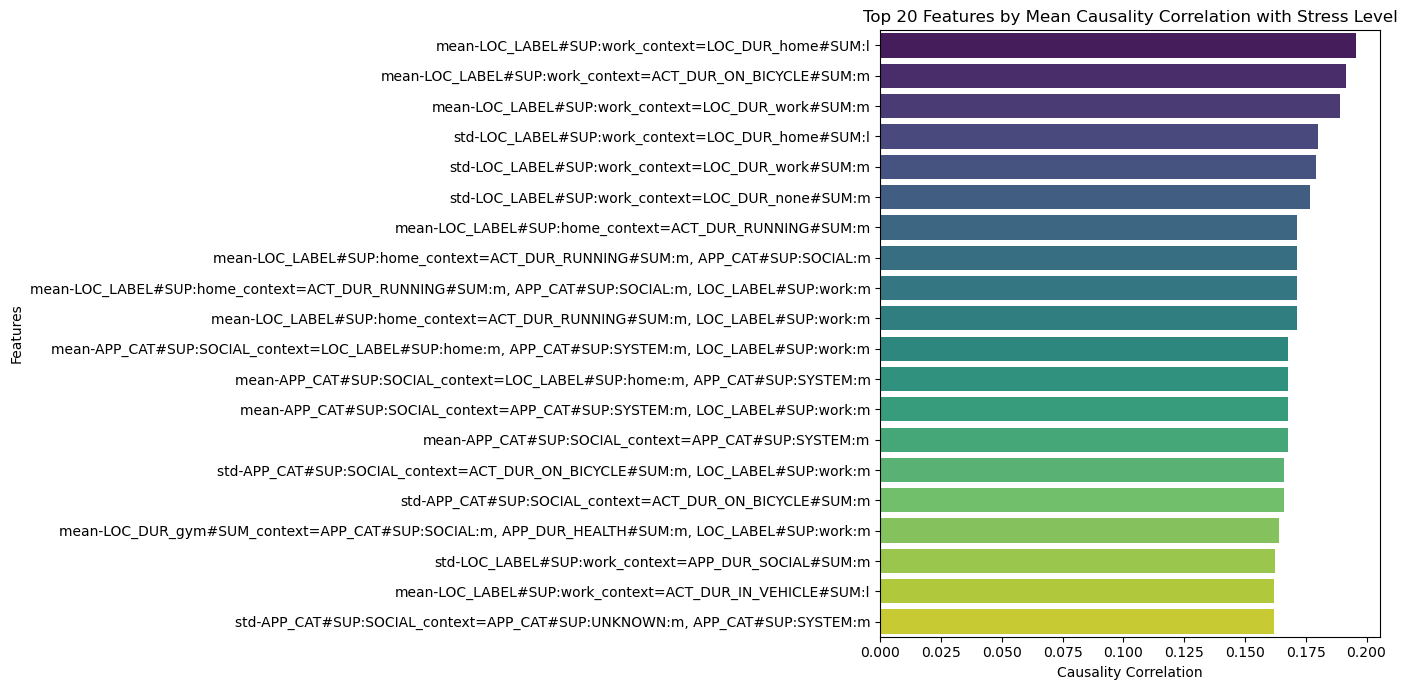

In [107]:
# import pandas as pd

# # Assuming featuresCFF and _LABELS are already defined and loaded

# # Convert timestamp index to column if not already done
# if 'timestamp' not in featuresCFF.index.names:
#     featuresCFF = featuresCFF.reset_index()

# # Initialize a DataFrame to store results
# results = pd.DataFrame(columns=['Feature', 'Correlation', 'P-value'])

# # Iterate over each column in featuresCFF
# for column in featuresCFF.columns:
#     if column != 'timestamp':  # Assuming 'timestamp' is not to be analyzed
#         data = pd.DataFrame({
#             'X': featuresCFF[column].values,
#             'Y': _LABELS['stressLevel'].values
#         })

#         X = data['X']
#         Y = data['Y']

#         # inputs
#         tau = 1  # time lag
#         E = 2  # shadow manifold embedding dimensions
#         L = len(X)  # length of time period to consider

#         # if we wish to check if X causes Y
#         ccm1 = ccm(X, Y, tau, E, L)

#         # causality X -> Y
#         # returns: (correlation ("strength" of causality), p-value(significance))
#         corr_, p = ccm1.causality()

#         # Store results
#         results = results.append({'Feature': column, 'Correlation': corr_, 'P-value': p}, ignore_index=True)


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming featuresCFF and _LABELS are already defined and loaded
# Drop columns named 'index' or starting with 'level...'
columns_to_drop = [col for col in featuresCFF.columns if col == 'index' or col.startswith('level')]
featuresCFF = featuresCFF.drop(columns=columns_to_drop)

# Reset index and rename 'uid' to 'pid' in _LABELS
_LABELS = _LABELS.reset_index().rename(columns={'uid': 'pid'}).set_index(['pid', 'timestamp'])

# Initialize a list to store results
results_list = []

# Get list of unique pids
unique_pids = featuresCFF.index.get_level_values('pid').unique()

# Iterate over each pid
for pid in unique_pids:
    # Filter data for the current pid
    features_pid = featuresCFF.loc[pid].reset_index()
    features_pid['timestamp'] = pd.to_datetime(features_pid['timestamp'], errors='coerce')

    labels_pid = _LABELS.loc[pid].reset_index()

    # Merge features and labels on 'timestamp'
    data = pd.merge(
        features_pid,
        labels_pid[['timestamp', 'stressLevel']],
        on=['timestamp'],
        how='inner'
    )

    # Iterate over each feature column
    for column in features_pid.columns:
        if column not in ['pid', 'timestamp']:  # Skip non-feature columns
            # Extract X and Y
            X = data[column]
            Y = data['stressLevel']

            # Ensure X and Y are numeric and convert to NumPy arrays
            X = pd.to_numeric(X, errors='coerce').values
            Y = pd.to_numeric(Y, errors='coerce').values

            # Drop rows with NaN values in X or Y
            valid_indices = ~np.isnan(X) & ~np.isnan(Y)
            X = X[valid_indices]
            Y = Y[valid_indices]

            # Skip if data is empty after dropping NaN values
            if len(X) == 0 or len(Y) == 0:
                print(f"Warning: For pid {pid}, column '{column}' has no valid data. Skipping.")
                continue

            # Inputs for CCM
            tau = 1  # time lag
            E = 2  # shadow manifold embedding dimensions
            L = len(X)  # length of time period to consider

            # Check if X causes Y using CCM
            ccm1 = ccm(X, Y, tau, E, L)

            # Get causality results: (correlation, p-value)
            corr_, p = ccm1.causality()

            # Store results if p-value is significant (p < 0.05)
            if p < 0.05:
                results_list.append({'Feature': column, 'Correlation': corr_, 'P-value': p, 'pid': pid})

# Convert results list to a DataFrame
results = pd.DataFrame(results_list)

# Group by feature and calculate mean causality for each feature
if not results.empty:
    mean_causality_per_feature = results.groupby('Feature')['Correlation'].mean().reset_index()
    
    # Sort by mean causality and select the top 20 features
    top_20_features = mean_causality_per_feature.sort_values(by='Correlation', ascending=False).head(20)
    
    # Visualize results
    plt.figure(figsize=(14, 7))
    sns.barplot(
        x='Correlation',
        y='Feature',
        data=top_20_features,
        palette='viridis'
    )
    plt.xlabel('Causality Correlation')
    plt.ylabel('Features')
    plt.title('Top 20 Features by Mean Causality Correlation with Stress Level')
    plt.tight_layout()
    plt.show()
else:
    print("No significant causality found (p < 0.05).")

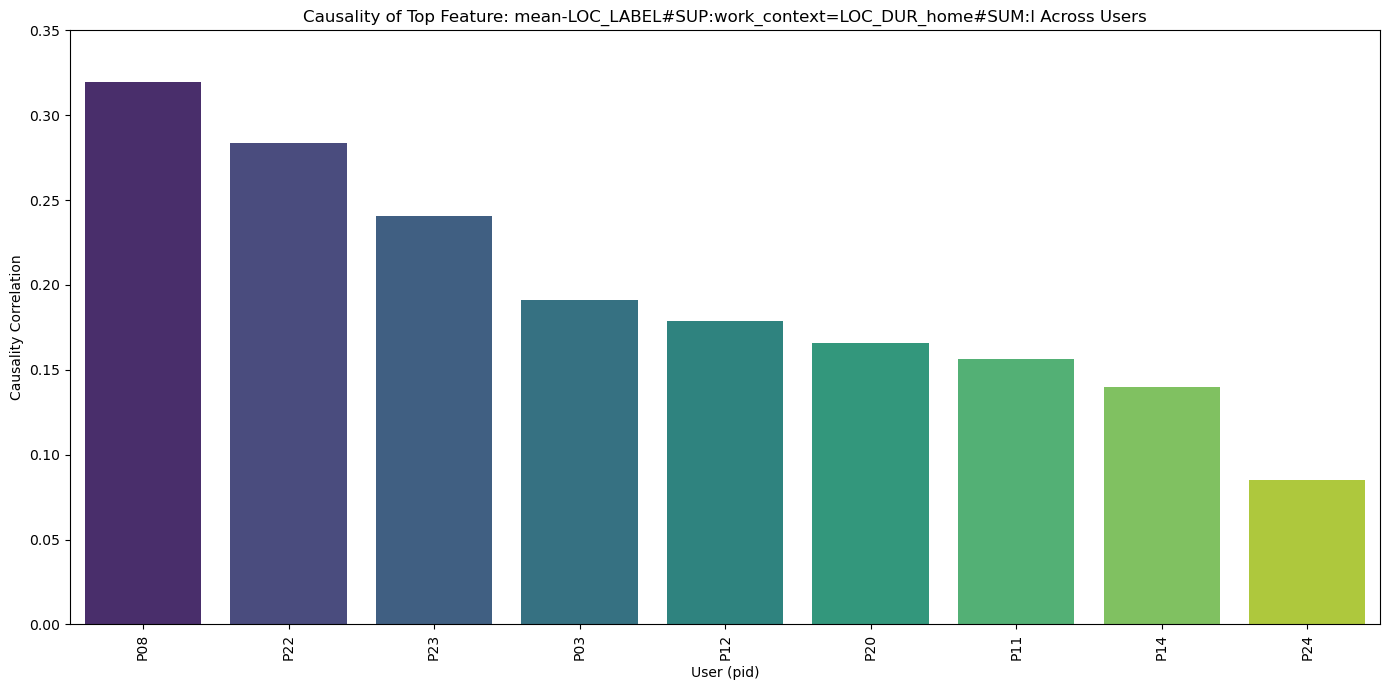

In [109]:
# Identify the top 1 feature
top_feature = mean_causality_per_feature.sort_values(by='Correlation', ascending=False).iloc[0]['Feature']
# Extract correlations for the top feature
top_feature_results = results[results['Feature'] == top_feature]

# Sort by correlation for better visualization
top_feature_results = top_feature_results.sort_values(by='Correlation', ascending=False)

# Plot using a bar plot
plt.figure(figsize=(14, 7))
sns.barplot(
    x='pid', 
    y='Correlation', 
    data=top_feature_results, 
    palette='viridis'
)
plt.xlabel('User (pid)')
plt.ylabel('Causality Correlation')
plt.ylim(0, 0.35)
plt.title(f'Causality of Top Feature: {top_feature} Across Users')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Include all users (without testing for p value)

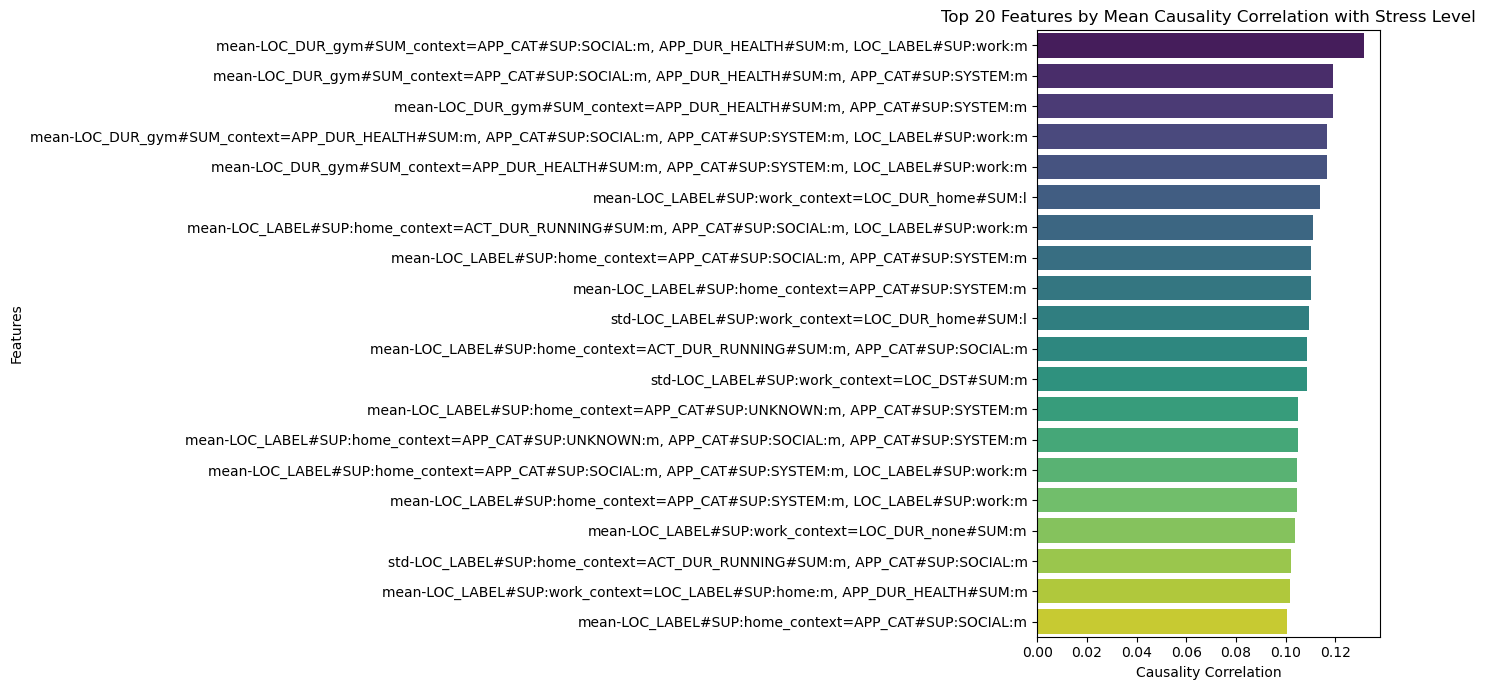

In [100]:
# import pandas as pd

# # Assuming featuresCFF and _LABELS are already defined and loaded

# # Convert timestamp index to column if not already done
# if 'timestamp' not in featuresCFF.index.names:
#     featuresCFF = featuresCFF.reset_index()

# # Initialize a DataFrame to store results
# results = pd.DataFrame(columns=['Feature', 'Correlation', 'P-value'])

# # Iterate over each column in featuresCFF
# for column in featuresCFF.columns:
#     if column != 'timestamp':  # Assuming 'timestamp' is not to be analyzed
#         data = pd.DataFrame({
#             'X': featuresCFF[column].values,
#             'Y': _LABELS['stressLevel'].values
#         })

#         X = data['X']
#         Y = data['Y']

#         # inputs
#         tau = 1  # time lag
#         E = 2  # shadow manifold embedding dimensions
#         L = len(X)  # length of time period to consider

#         # if we wish to check if X causes Y
#         ccm1 = ccm(X, Y, tau, E, L)

#         # causality X -> Y
#         # returns: (correlation ("strength" of causality), p-value(significance))
#         corr_, p = ccm1.causality()

#         # Store results
#         results = results.append({'Feature': column, 'Correlation': corr_, 'P-value': p}, ignore_index=True)


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming featuresCFF and _LABELS are already defined and loaded
# Drop columns named 'index' or starting with 'level...'
columns_to_drop = [col for col in featuresCFF.columns if col == 'index' or col.startswith('level')]
featuresCFF = featuresCFF.drop(columns=columns_to_drop)

# Reset index and rename 'uid' to 'pid' in _LABELS
_LABELS = _LABELS.reset_index().rename(columns={'uid': 'pid'}).set_index(['pid', 'timestamp'])

# Initialize a list to store results
results_list = []

# Get list of unique pids
unique_pids = featuresCFF.index.get_level_values('pid').unique()

# Iterate over each pid
for pid in unique_pids:
    # Filter data for the current pid
    features_pid = featuresCFF.loc[pid].reset_index()
    features_pid['timestamp'] = pd.to_datetime(features_pid['timestamp'], errors='coerce')

    labels_pid = _LABELS.loc[pid].reset_index()

    # Merge features and labels on 'timestamp'
    data = pd.merge(
        features_pid,
        labels_pid[['timestamp', 'stressLevel']],
        on=['timestamp'],
        how='inner'
    )

    # Iterate over each feature column
    for column in features_pid.columns:
        if column not in ['pid', 'timestamp']:  # Skip non-feature columns
            # Extract X and Y
            X = data[column]
            Y = data['stressLevel']

            # Ensure X and Y are numeric and convert to NumPy arrays
            X = pd.to_numeric(X, errors='coerce').values
            Y = pd.to_numeric(Y, errors='coerce').values

            # Drop rows with NaN values in X or Y
            valid_indices = ~np.isnan(X) & ~np.isnan(Y)
            X = X[valid_indices]
            Y = Y[valid_indices]

            # Skip if data is empty after dropping NaN values
            if len(X) == 0 or len(Y) == 0:
                print(f"Warning: For pid {pid}, column '{column}' has no valid data. Skipping.")
                continue

            # Inputs for CCM
            tau = 1  # time lag
            E = 2  # shadow manifold embedding dimensions
            L = len(X)  # length of time period to consider

            # Check if X causes Y using CCM
            ccm1 = ccm(X, Y, tau, E, L)

            # Get causality results: (correlation, p-value)
            corr_, p = ccm1.causality()

            # Store all results disregarding p-value
            results_list.append({'Feature': column, 'Correlation': corr_, 'P-value': p, 'pid': pid})

# Convert results list to a DataFrame
results = pd.DataFrame(results_list)

# Group by feature and calculate mean causality for each feature
if not results.empty:
    mean_causality_per_feature = results.groupby('Feature')['Correlation'].mean().reset_index()
    
    # Sort by mean causality and select the top 20 features
    top_20_features = mean_causality_per_feature.sort_values(by='Correlation', ascending=False).head(20)
    
    # Visualize results
    plt.figure(figsize=(14, 7))
    sns.barplot(
        x='Correlation',
        y='Feature',
        data=top_20_features,
        palette='viridis'
    )
    plt.xlabel('Causality Correlation')
    plt.ylabel('Features')
    plt.title('Top 20 Features by Mean Causality Correlation with Stress Level')
    plt.tight_layout()
    plt.show()
else:
    print("No significant causality found (p < 0.05).")

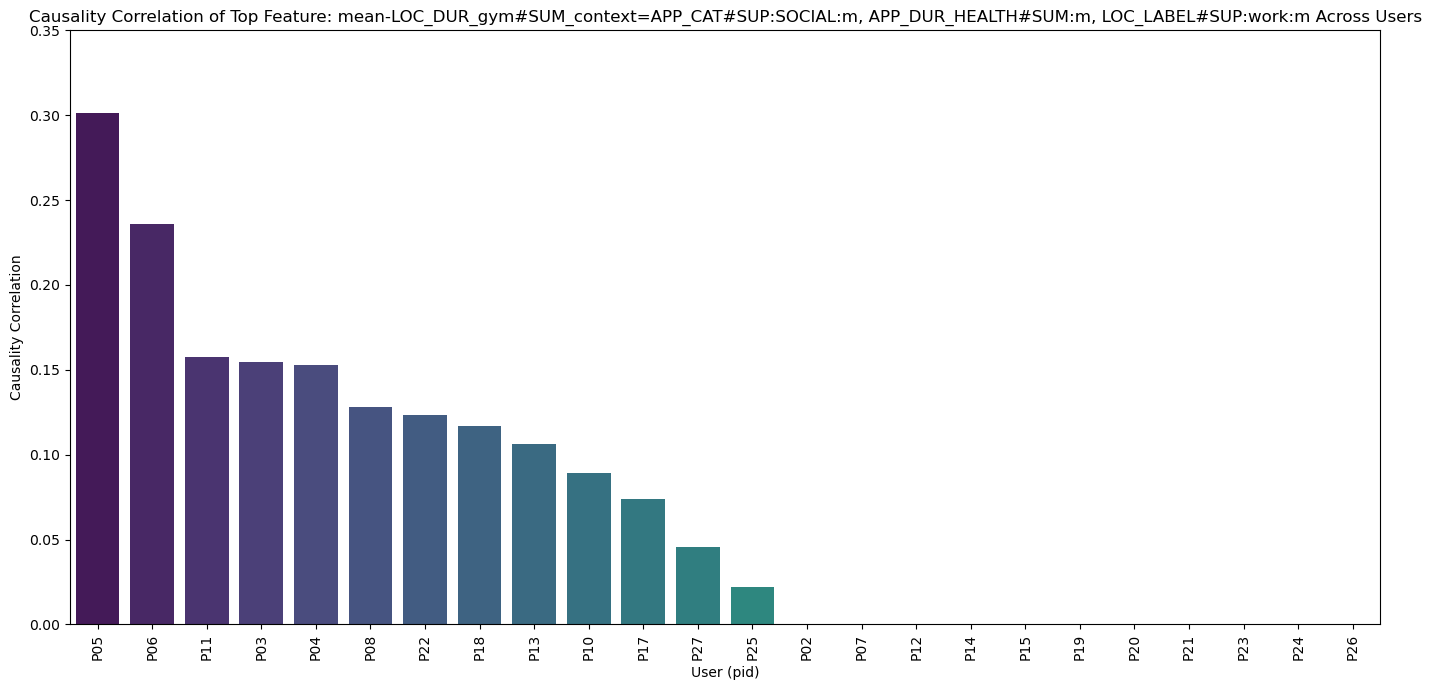

In [104]:
# Identify the top 1 feature
top_feature = mean_causality_per_feature.sort_values(by='Correlation', ascending=False).iloc[0]['Feature']
# Extract correlations for the top feature
top_feature_results = results[results['Feature'] == top_feature]

# Sort by correlation for better visualization
top_feature_results = top_feature_results.sort_values(by='Correlation', ascending=False)

# Plot using a bar plot
plt.figure(figsize=(14, 7))
sns.barplot(
    x='pid', 
    y='Correlation', 
    data=top_feature_results, 
    palette='viridis'
)
plt.xlabel('User (pid)')
plt.ylabel('Causality Correlation')
plt.ylim(0, 0.35)
plt.title(f'Causality Correlation of Top Feature: {top_feature} Across Users')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Original CCM Implemenation

In [64]:
# import pandas as pd
# import math
# import pyEDM
# import numpy as np

# def CI_bound(rhos, CI):
#     lower = np.nanpercentile(rhos, (100.0 - CI) / 2.0, axis=1)[:, np.newaxis]
#     upper = np.nanpercentile(rhos, 100.0 - (100.0 - CI) / 2.0, axis=1)[:, np.newaxis]
#     return lower, upper

# def CCM_single(df, timestamp, causer, causee, num_Surrogate, threshold_converging, surrogate_method):
#     """
#     Perform Convergent Cross Mapping (CCM) for a single pair of variables: causer and causee.
    
#     Parameters:
#     df (pd.DataFrame): DataFrame containing the time series data.
#     timestamp (str): Name of the timestamp column.
#     causer (str): Name of the causer variable column.
#     causee (str): Name of the causee variable column.
#     num_Surrogate (int): Number of surrogate data sets to generate.
#     threshold_converging (float): Threshold for convergence in CCM.
#     surrogate_method (str): Method for generating surrogate data.
    
#     Returns:
#     dict: A dictionary containing CCM results or failure messages.
#     """
#     # Parameters for CCM
#     stepsize = 1
#     cutoff = math.floor(len(df) * 0.7)
#     lib = "1 {}".format(cutoff)
#     pred = "{} {}".format(cutoff, len(df))
#     sizes = "10 {} {}".format(len(df), stepsize)  # for CCM

#     # Check for NaN values and handle them (e.g., fill with interpolation)
#     df = df.fillna(method='ffill').fillna(method='bfill')

#     # Extract columns for causer and causee
#     df_causer = df[[timestamp, causer]].copy()
#     df_causee = df[[timestamp, causee]].copy()

#     result = {
#         'causer_to_causee': None,
#         'causee_to_causer': None,
#         'significance_causer_to_causee': None,
#         'significance_causee_to_causer': None,
#         'fail_message': 0
#     }

#     try:
#         # Determine optimal embedding dimension (E) for causer
#         E1_result = pyEDM.EmbedDimension(showPlot=False, dataFrame=df_causer, lib=lib, pred=pred, 
#                                          columns=causer, target=causer, maxE=6, tau=-1)
#         E1_result = int(E1_result.loc[E1_result['rho'].idxmax()]['E'])

#         # Determine optimal embedding dimension (E) for causee
#         E2_result = pyEDM.EmbedDimension(showPlot=False, dataFrame=df_causee, lib=lib, pred=pred, 
#                                          columns=causee, target=causee, maxE=6, tau=-1)
#         E2_result = int(E2_result.loc[E2_result['rho'].idxmax()]['E'])

#         # Test for nonlinearity using PredictNonlinear for causer
#         test_causer = pyEDM.PredictNonlinear(showPlot=False, dataFrame=df_causer, lib=lib, pred=pred, 
#                                              columns=causer, E=E1_result)
#         theta_causer = test_causer.loc[test_causer['rho'].idxmax()]['Theta']
#         if theta_causer == 0:
#             result['fail_message'] = 1
#             return result

#         # Test for nonlinearity using PredictNonlinear for causee
#         test_causee = pyEDM.PredictNonlinear(showPlot=False, dataFrame=df_causee, lib=lib, pred=pred, 
#                                              columns=causee, E=E2_result)
#         theta_causee = test_causee.loc[test_causee['rho'].idxmax()]['Theta']
#         if theta_causee == 0:
#             result['fail_message'] = 1
#             return result

#         # Perform CCM from causer to causee
#         v1_xmap_v2 = pyEDM.CCM(showPlot=False, dataFrame=df, E=E1_result, columns=causer, target=causee, 
#                                libSizes=sizes, sample=100, random=True, replacement=True)
#         v1_xmap_v2 = v1_xmap_v2[['LibSize', f'{causer}:{causee}']]

#         # Perform CCM from causee to causer
#         v2_xmap_v1 = pyEDM.CCM(showPlot=False, dataFrame=df, E=E2_result, columns=causee, target=causer, 
#                                libSizes=sizes, sample=100, random=True, replacement=True)
#         v2_xmap_v1 = v2_xmap_v1[['LibSize', f'{causee}:{causer}']]

#         # Check convergence
#         diff_i_v1_xmap_v2 = v1_xmap_v2[f'{causer}:{causee}'].iloc[-1] - v1_xmap_v2[f'{causer}:{causee}'].iloc[0]
#         diff_i_v2_xmap_v1 = v2_xmap_v1[f'{causee}:{causer}'].iloc[-1] - v2_xmap_v1[f'{causee}:{causer}'].iloc[0]

#         if max(diff_i_v1_xmap_v2, diff_i_v2_xmap_v1) <= threshold_converging:
#             result['fail_message'] = 2
#             return result

#         # Generate surrogate data for causer
#         df1_surrogate = pyEDM.SurrogateData(dataFrame=df_causer, column=causer, method=surrogate_method, numSurrogates=num_Surrogate)
#         surrogate_rhos1 = np.zeros((len(v1_xmap_v2), num_Surrogate))
#         for i in range(1, num_Surrogate + 1):
#             surrogate_df = df.copy()
#             surrogate_df[causer] = df1_surrogate[f'{causer}_{i}']
#             surrogate_rho = pyEDM.CCM(showPlot=False, dataFrame=surrogate_df, E=E1_result, columns=causer, target=causee, 
#                                       libSizes=sizes, sample=100, random=True, replacement=True)[f'{causer}:{causee}'].values
#             surrogate_rhos1[:, i - 1] = surrogate_rho

#         # Generate surrogate data for causee
#         df2_surrogate = pyEDM.SurrogateData(dataFrame=df_causee, column=causee, method=surrogate_method, numSurrogates=num_Surrogate)
#         surrogate_rhos2 = np.zeros((len(v2_xmap_v1), num_Surrogate))
#         for i in range(1, num_Surrogate + 1):
#             surrogate_df = df.copy()
#             surrogate_df[causee] = df2_surrogate[f'{causee}_{i}']
#             surrogate_rho = pyEDM.CCM(showPlot=False, dataFrame=surrogate_df, E=E2_result, columns=causee, target=causer, 
#                                       libSizes=sizes, sample=100, random=True, replacement=True)[f'{causee}:{causer}'].values
#             surrogate_rhos2[:, i - 1] = surrogate_rho

#         # Compute confidence intervals
#         CI = 95
#         lower1, upper1 = CI_bound(surrogate_rhos1, CI)
#         lower2, upper2 = CI_bound(surrogate_rhos2, CI)

#         # Significance testing
#         original_rho1 = v1_xmap_v2[f'{causer}:{causee}'].values
#         original_rho2 = v2_xmap_v1[f'{causee}:{causer}'].values

#         diff_v1_v2_surrogate = original_rho1[-1] - upper1[-1]
#         diff_v2_v1_surrogate = original_rho2[-1] - upper2[-1]

#         if max(diff_v1_v2_surrogate, diff_v2_v1_surrogate) <= 0:
#             result['fail_message'] = 3
#             return result

#         # Populate the result dictionary
#         result['causer_to_causee'] = diff_i_v1_xmap_v2
#         result['causee_to_causer'] = diff_i_v2_xmap_v1
#         result['significance_causer_to_causee'] = diff_v1_v2_surrogate
#         result['significance_causee_to_causer'] = diff_v2_v1_surrogate

#     except Exception as e:
#         result['fail_message'] = 4
#         result['error_message'] = str(e)
    
#     return result



In [65]:
# import pandas as pd

# # Example: Suppose we have already loaded `featuresCFF` and `_LABELS`
# # and we want to run CCM_single on each feature column to see if it influences stressLevel.

# # 1. Ensure 'timestamp' is a column if it's currently in the index
# if 'timestamp' not in featuresCFF.columns:
#     featuresCFF = featuresCFF.reset_index()  # This puts 'pid' and 'timestamp' into columns if they were in the index

# # 2. Define parameters for CCM_single
# NUM_SURROGATE = 25
# THRESHOLD_CONVERGING = 0.05
# SURROGATE_METHOD = 'seasonal'

# # 3. Create a results DataFrame
# results = pd.DataFrame(columns=[
#     'Feature',
#     'causer_to_causee',
#     'causee_to_causer',
#     'signif_causer_to_causee',
#     'signif_causee_to_causer',
#     'fail_message'
# ])

# # 4. Iterate over columns in `featuresCFF` (excluding 'timestamp' and 'pid' if present)
# for col in featuresCFF.columns:
#     if col not in ['timestamp', 'pid']:
#         # Build a DataFrame for CCM_single
#         # 'time' should match the 'timestamp' argument in CCM_single
#         # 'causer' is the column of interest
#         # 'causee' is the stress level (from _LABELS)

#         # Ensure we have the same length in _LABELS as in featuresCFF
#         # If necessary, you might need to align them by index or pid.
#         # For simplicity, assume they're already aligned row-by-row.
#         df_input = pd.DataFrame({
#             'time': featuresCFF['timestamp'],   # from the reset index
#             'causer': featuresCFF[col],
#             'causee': _LABELS['stressLevel']
#         })

#         # 5. Call CCM_single
#         result_ccm = CCM_single(
#             df=df_input,
#             timestamp='time',
#             causer='causer',
#             causee='causee',
#             num_Surrogate=NUM_SURROGATE,
#             threshold_converging=THRESHOLD_CONVERGING,
#             surrogate_method=SURROGATE_METHOD
#         )

#         # 6. Store results
#         results = results.append({
#             'Feature': col,
#             'causer_to_causee': result_ccm['causer_to_causee'],
#             'causee_to_causer': result_ccm['causee_to_causer'],
#             'signif_causer_to_causee': result_ccm['significance_causer_to_causee'],
#             'signif_causee_to_causer': result_ccm['significance_causee_to_causer'],
#             'fail_message': result_ccm['fail_message']
#         }, ignore_index=True)

# # 7. Analyze or print the results
# print(results)